In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
import math
import csv
import statsmodels.api as sm
import statsmodels.formula.api as smf
import random
import matplotlib.pyplot as plt
import pylab as plt
import plotly.plotly as py
import plotly
import plotly.graph_objs as go
from scipy.stats.stats import pearsonr   
from sklearn import linear_model, datasets
import itertools

In [1132]:
#########################################################################
##[FUNCTION] data_creation simulates data for a given number of 
## individuals(indiv) over a set amount of time (max_time), and can 
## include as many covariates as desired (number_of_covariates)

## -- need to create the functionality for multiple covariates

#########################################################################


def data_creation2(indiv, max_time, number_of_covariates, Y_full, alpha, beta): 

    columns = ["indiv", "time","U", "A", "Y",  "L1"]
    df = pd.DataFrame(columns = columns)
     
    ## creating an unobserved variable that affects covariates 
    U = np.random.uniform(low = 0.1, high = 1, size = indiv)
            
    for jj in range(0, max_time+1): 
        if jj == 0: 
            x_L = alpha[0] + alpha[5]*U 
            L1 = np.random.binomial(n=1, p = np.exp(x_L)/(1+np.exp(x_L)))

            x_A = beta[0] + beta[1]*L1 
            A = np.random.binomial(n=1, p = np.exp(x_A)/(1+np.exp(x_A)))

            df = pd.DataFrame({"indiv":range(1,indiv+1), "time":jj,"U":U, "A":A, \
                 "Y":[math.nan]*indiv, "L1":L1})
            
        elif jj == 1: 
            x_L = np.sum(alpha*np.transpose(np.array([[1.0]*indiv, df["L1"]\
                  [(df.time == jj-1)], [0.0]*indiv, df["A"][(df.time == jj-1)],\
                  [0.0]*indiv, U])), axis = 1)

            L1 = np.random.binomial(n=1, p = np.exp(x_L)/(1+np.exp(x_L)))


            x_A = np.sum(beta*np.transpose(np.array([[1.0]*indiv, L1, df["L1"]\
                  [(df.time == jj-1)],df["A"][(df.time == jj-1)], [0.0]*indiv ])), axis = 1)
                         
            A = np.random.binomial(n=1, p = np.exp(x_A)/(1+np.exp(x_A)))

            temp_df = pd.DataFrame({"indiv":range(1,indiv+1), "time":jj, "U":U, "A":A,\
                      "Y":[math.nan]*indiv, "L1":L1})
            df = pd.concat([df, temp_df])

        else: 
            x_L = np.sum(alpha*np.transpose(np.array([[1.0]*indiv, df["L1"][(df.time == jj-1)], \
                  df["L1"][(df.time == jj-2)], df["A"][(df.time == jj-1)], \
                  df["A"][(df.time == jj-2)], U])), axis = 1)

            L1 = np.random.binomial(n=1, p = np.exp(x_L)/(1+np.exp(x_L)))


            x_A = np.sum(beta*np.transpose(np.array([[1.0]*indiv,L1,df["L1"][(df.time == jj-1)],\
                  df["A"][(df.time == jj-1)] , df["A"][(df.time == jj-2)]])), axis = 1)

            A = np.random.binomial(n=1, p = np.exp(x_A)/(1+np.exp(x_A)))

            if jj == max_time: 
                x_Y = U + 3*df.groupby(["indiv"]).A.mean()
                Y = np.random.binomial(n=1, p = np.exp(x_Y)/(1+np.exp(x_Y)))                
                temp_df = pd.DataFrame({"indiv":range(1,indiv+1), "time":jj,"U":U, "A":A, \
                          "Y":Y, "L1":L1})
                df = pd.concat([df, temp_df])


            else: 
                temp_df = pd.DataFrame({"indiv":range(1,indiv+1), "time":jj,"U":U, "A":A, \
                          "Y":[math.nan]*indiv, "L1":L1})
                df = pd.concat([df, temp_df])


    # creating shifted values 
    if Y_full == True:
        for kk in range(1,max_time+1):
            df["L1_"+str(kk)] = df.L1.shift(kk)
            df["A_"+str(kk)] = df.A.shift(kk)
    else:
        for kk in range(1,4):
            df["L1_"+str(kk)] = df.L1.shift(kk)
            df["A_"+str(kk)] = df.A.shift(kk)
            
    df.sort_values(by=['time', 'indiv'], ascending=[True, True])

    return(df); 

In [3]:
#########################################################################
##[FUNCTION] Y_model_creation creates the linear regression model for 
## the observed Ys based on the treatments (A) and covariates (L)  

#########################################################################

def Y_model_creation(df, max_time): 
    temp_df = df[df.time == max_time]
    # train_columns ='+'.join(map(str, np.append(list(df)[0:2],list(df)[6:])))
    train_columns = list(df)[0:2]+list(df)[6:]
    temp_df = temp_df.astype(float)
    # Y_model = smf.ols("Y~"+train_columns, data=temp_df).fit(); 
    Y_model = sm.Logit(np.asarray(temp_df["Y"]), \
                       np.asarray(sm.add_constant(temp_df[train_columns]))).fit(); 
    return(Y_model)

In [4]:
#########################################################################
##[FUNCTION] covariate_model_creation creates the logistic regression 
## for the observed covariate (L) data from the previous covariates 
## and the previous treatments (A) 

## -- need to create the functionality for multiple covariates
## SHOULD THIS BE FOR ALL HISTORY UP TO THAT POINT TO BE MORE 
## ACCURATE WHEN CALCULATING THE EXPECTATION??? 

#########################################################################


def covariate_model_creation(df, max_time): 
    columns = ["time", "gamma_0", "gamma_1", "gamma_2", "gamma_3", "gamma_4", \
              "gamma_5", "gamma_6"]
    train_columns = ["L1_1", "L1_2", "L1_3", "A_1", "A_2",  "A_3"]
    L1_model_df = pd.DataFrame(columns = columns)

    for ii in range(1, (max_time+1)): 
        temp_df = df[df.time == ii] 
        if ii == 1: 
            L1_model = sm.Logit(np.asarray(temp_df["L1"]), \
                       np.asarray(sm.add_constant(temp_df[["L1_1", "A_1"]]))).fit(); 
            L1_model_df = L1_model_df.append(pd.DataFrame([ii] + \
                         [L1_model.params[i] for i in range(0,2)] + ["Nan"] + \
                         ["Nan"] + [L1_model.params[2]] + ["Nan"] + ["Nan"], \
                         index = columns).transpose(), ignore_index=True)
        elif ii == 2: 
            L1_model = sm.Logit(np.asarray(temp_df["L1"]), \
                       np.asarray(sm.add_constant(temp_df[["L1_1", "L1_2", \
                       "A_1", "A_2"]]))).fit(); 
            L1_model_df = L1_model_df.append(pd.DataFrame([ii] + [L1_model.params[i] \
                          for i in range(0,3)] + ["Nan"] + [L1_model.params[i] for i \
                          in range(3,5)] + ["Nan"], index = columns).transpose(), \
                          ignore_index=True)
        else: 
            L1_model = sm.Logit(np.asarray(temp_df["L1"]), \
                       np.asarray(sm.add_constant(temp_df[train_columns]))).fit(); 
            L1_model_df = L1_model_df.append(pd.DataFrame([ii] + [L1_model.params[i] for \
                          i in range(0,7)], index = columns).transpose(), \
                          ignore_index=True)
    return(L1_model_df)

In [196]:
#########################################################################
##[FUNCTION] treatment_model_creation creates the logistic regression 
## for the observed treatment (A) data from the current and previous 
## covariates and the previous treatments (A) 

## -- need to create the functionality for multiple covariates
#########################################################################


def treatment_model_creation(df, max_time): 
    columns = ["time", "zeta_0", "zeta_1", "zeta_2", "zeta_3", "zeta_4"]
    train_columns = ["L1", "L1_1", "A_1", "A_2"]
    A_model_df = pd.DataFrame(columns = columns)

    for ii in range(0, (max_time+1)): 
        temp_df = df[df.time == ii] 
        if ii == 0: 
            A_model = sm.Logit(np.asarray(temp_df["A"]), np.asarray(sm.add_constant(\
                      temp_df[["L1"]]))).fit()
            A_model_df = A_model_df.append(pd.DataFrame([ii] + [A_model.params[i] \
                         for i in range(0,2)] + [float("nan")] + [float("nan")] +[float("nan")], index = columns).transpose(),\
                         ignore_index=True)
        elif ii == 1: 
            A_model = sm.Logit(np.asarray(temp_df["A"]), np.asarray(sm.add_constant(\
                      temp_df[["L1", "L1_1", "A_1"]]))).fit()
            A_model_df = A_model_df.append(pd.DataFrame([ii] + [A_model.params[i] \
                         for i in range(0,4)] + [float("nan")], index = columns).transpose(),\
                         ignore_index=True)
        else: 
            A_model = sm.Logit(np.asarray(temp_df["A"]), np.asarray(sm.add_constant(\
                      temp_df[train_columns]))).fit()
            A_model_df = A_model_df.append(pd.DataFrame([ii] + [A_model.params[i] \
                         for i in range(0,5)],index = columns).transpose(), \
                         ignore_index=True)
    return(A_model_df)


In [379]:
#########################################################################
##[FUNCTION] simulation_run calculates the causal effect over an  
## established number of repetitions using the models for outcome (Y) 
## and the covariates (L) 

## -- need to create the functionality for multiple covariates

#########################################################################


def simulation_run2(df, Y_model, L1_model_df, max_time, Y_full, test_value): 
    reps = 10000
    final_results = np.empty(reps) 

    ### establishing treatment of interest
    A_test = [test_value]*(max_time+1) 

    values = pd.DataFrame(np.random.choice(np.array(df["L1"][df["time"] == 0]), reps))
    prod = np.empty(reps) 
    
    prod[np.where(values[0] == 0)] = 1-np.mean(list(df["L1"][df["time"] == 0]))
    prod[np.where(values[0] != 0)] = np.mean(list(df["L1"][df["time"] == 0]))

    values[1] = np.sum(np.array([L1_model_df.ix[0,][i] for i in [1,2,5]])*np.transpose(\
                np.array([[1.0]*reps,list(values[0]),[A_test[0]]*reps])), axis = 1)
    p_v = np.exp(values[1])/(1+np.exp(values[1]))
    values[1] = np.random.binomial(n=1, p = p_v)
    prod = prod*p_v
    
    values[2] = np.sum(np.array([L1_model_df.ix[1,][i] for i in [1,2,3,5,6]])*\
                np.transpose(np.array([[1.0]*reps, list(values[1]),list(values[0]), \
                [A_test[1]]*reps, [A_test[0]]*reps])), axis = 1 )
    p_v = (np.exp(values[2])/(1+np.exp(values[2]))) 
    values[2] = np.random.binomial(n=1, p=p_v)
    prod = prod*p_v
    
                                                               

    for jj in range(3, max_time+1):
        values[jj] = np.sum(np.array([L1_model_df.ix[jj-1,][i] for i in range(1,8)])\
                     *np.transpose(np.array([[1.0]*reps,list(values[jj-1]),\
                     list(values[jj-2]), list(values[jj-3]), [A_test[jj-1]]*reps, \
                     [A_test[jj-2]]*reps, [A_test[jj-3]]*reps])), axis = 1)
        p_v = (np.exp(values[jj])/(1+np.exp(values[jj]))) 
        values[jj] = np.random.binomial(n=1, p=p_v)
        prod = prod*p_v

    if Y_full == "TRUE": 
        Y_A = [A_test]*reps
        Y_L = np.array(values)
        Y_exp = np.array(Y_model.params[0])*([1.0]*reps) + np.sum(Y_A*np.array(\
                [Y_model.params[i] for i in [1,4,6,8,10,12,14,16,18,20,22,24]]), \
                axis = 1)+np.sum([Y_model.params[i] for i in \
                [2,3,5,7,9,11,13,15,17,19,21,23]]*Y_L, axis = 1)
        Y_exp = (np.exp(Y_exp)/(1+np.exp(Y_exp)))
        
    else: 
        Y_A = [A_test*4]*reps
        Y_L = np.array([values[0], values[1], values[2], values[3], values[4]])
        Y_exp = np.array(Y_model.params[0])*([1.0]*reps) + np.sum(Y_A*np.array(\
                [Y_model.params[i] for i in [1,4,6,8]]), axis = 1)+np.sum(\
                [Y_model.params[i] for i in [2,3,5,7]]*Y_L, axis = 1)
        Y_exp = (np.exp(Y_exp)/(1+np.exp(Y_exp)))

    return(np.mean(prod*Y_exp)) 

In [709]:
#########################################################################
##[FUNCTION] pi_function creates the w_m function given the following:
## the alpha model of A_{m,i}, the dataframe, the time (m), and an 
## indicator of whether this is the correct or incorrect model 

## do I need to do something in here like 1-expit for those A_j == 0?? 
## i.e. what I did in the last line here 
#########################################################################

def pi_function(m, alpha_model, df, indiv, alpha_wrong): 
    product = [1]*indiv
    for jj in range(3, m+1):
        if alpha_wrong[jj] == False: 
            x = alpha_model[jj].predict(sm.add_constant(df[df.time == jj][["L1", "L1_1", "L1_2", "A_1", \
                "A_2"]], has_constant='add'))
        else: 
            x = alpha_model[jj].predict(sm.add_constant(df[df.time == jj][["L1_3", \
                "A_3"]], has_constant='add'))
        product = product*x
    
    x = np.array(np.divide([1]*indiv, product))
    x[np.where(df[df.time == m]["A_1"] == 0.0)] = 1 - x[np.where(df[df.time == m]["A_1"] == 0.0)]
    return(x)    

In [619]:
#########################################################################
##[FUNCTION] alpha_model_creation creates the logistic regression 
## for the observed treatment (A) data from the current and previous 
## covariates and the previous treatments (A) over all time periods and
## individuals 

## -- need to create the functionality for multiple covariates
#########################################################################


def alpha_model_creation(df, wrong): 
    temp_df = df[df["time"]>2.0]
    if wrong == True:
        alpha_model = sm.Logit(np.asarray(temp_df.A),np.asarray(sm.add_constant(\
                      temp_df[["L1_3", "A_3"]], has_constant='add'))).fit()

    else: 
        alpha_model = sm.Logit(np.asarray(temp_df.A),np.asarray(sm.add_constant(\
                      temp_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]], has_constant='add'))).fit()

    return(alpha_model)  

In [559]:
#########################################################################
##[FUNCTION] DR_estimate_creation calculates the causal effect for a 
## given treatment of interest (test_value), including an indicator 
## of whether the correct or incorrect model is being used 

#########################################################################

def DR_estimate_creation(test_value, max_time, df, indiv, wrong_alpha_model, wrong_s_model, alpha_model):
    
    A_test = [test_value]*indiv 
    model_df = pd.DataFrame(columns = ["time", "beta_0", "beta_1", "beta_2", \
                "beta_3", "beta_4", "beta_5", "beta_6", "phi"])
    time_counter = max_time+1
    T = df[df.time == max_time]["Y"]

    while(time_counter > 3.0): 
        
        time_df = df.loc[df.time == time_counter-1]
        time_df["T"] = np.array(T)
        pi = pi_function(time_counter-1, alpha_model, df, indiv, wrong_alpha_model) 
        time_df["pi"] = pi 
        if wrong_s_model == "TRUE":
            train_columns = list(time_df)[0:1]
            reg_columns = '+'.join(map(str, np.append(list(time_df)[0:1],["pi"])))
        else: 
            train_columns = list(time_df)[0:2] + list(time_df)[6:10]+["pi"]
            x = list(itertools.combinations(np.append(list(time_df)[0:2], list(time_df)[6:10]), 2))
            y = ['*'.join(map(str, np.array([x[i][0], x[i][1]]))) for i in range(len(x))]
            z = '+'.join(map(str, y))
            reg_mid_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
            reg_columns = '+'.join(map(str, np.array([reg_mid_columns, z])))

        time_df = time_df.astype(float)
        S_model = smf.ols("T~"+reg_columns, data=time_df).fit()
        
        pi2 = pi_function(time_counter-2, alpha_model, df, indiv, wrong_alpha_model)
        
        time_df["A"] = np.array(A_test)
        
        if test_value == 1: 
            if wrong_alpha_model == "TRUE":
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add"))
            else:
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", \
                    "A_2"]], has_constant = "add"))
                
        elif test_value == 0: 
            if wrong_alpha_model == "TRUE":
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add")))
            else:
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]], has_constant = "add")))

        time_df["pi"] = pi2
        T = sp.special.expit(S_model.predict(time_df[train_columns]))
        time_counter = time_counter-1
    
    values = np.array([np.mean(df.Y), np.mean(df.A), np.mean(df.L1), np.mean(df.U), \
             pearsonr(df.Y[df.time == 11], df.A[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.L1[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.U[df.time == 11])[0], \
             pearsonr(df.A, df.L1)[0], pearsonr(df.U, df.L1)[0], pearsonr(df.A, df.U)[0]])
    
    return(np.nanmean(T), values)  

In [631]:
#########################################################################
##[FUNCTION] DR_estimate_creation calculates the causal effect for a 
## given treatment of interest (test_value), including an indicator 
## of whether the correct or incorrect model is being used 

#########################################################################

def DR_estimate_creation_bin(test_value, max_time, df, indiv, wrong_alpha_model, wrong_s_model, alpha_model, int_term):
    
    A_test = [test_value]*indiv 
    model_df = pd.DataFrame(columns = ["time", "beta_0", "beta_1", "beta_2", \
                "beta_3", "beta_4", "beta_5", "beta_6", "phi"])
    time_counter = max_time+1
    T = df[df.time == max_time]["Y"]
    
    poly = sk.preprocessing.PolynomialFeatures(interaction_only = True)

    while(time_counter > 3.0): 
        time_df = df.loc[df.time == time_counter-1]
        pi = pi_function(time_counter-1, alpha_model, df, indiv, wrong_alpha_model) 
        time_df["pi"] = pi
        if wrong_s_model == True:
            train_columns = list(time_df)[0:2] + list(time_df)[12:14]+["pi"]
            # train_columns = list(time_df)[0:1]+["pi"]
            reg_columns = '+'.join(map(str, np.append(list(time_df)[0:2],np.append(list(time_df)[12:14], ["pi"]))))
            # reg_columns = '+'.join(map(str, np.append(list(time_df)[0:1], ["pi"])))
        else: 
            train_columns = list(time_df)[0:2] + list(time_df)[6:10]+["pi"]
            if int_term == True:
                x = list(itertools.combinations(np.append(list(time_df)[0:2], list(time_df)[6:10]), 2))
                y = ['*'.join(map(str, np.array([x[i][0], x[i][1]]))) for i in range(len(x))]
                z = '+'.join(map(str, y))
                reg_mid_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
                reg_columns = '+'.join(map(str, np.array([reg_mid_columns, z])))
            else:
                reg_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
        time_df = time_df.astype(float)
        
        formula = "T~"+reg_columns 
        glm_model = smf.glm(formula = formula, data = time_df, family=sm.families.Binomial(link=sm.families.links.logit))
        try:
             glm_results = glm_model.fit()
        except Exception as ex:
            return(float("nan"), float("nan"))
        
        pi2 = pi_function(time_counter-2, alpha_model, df, indiv, wrong_alpha_model)
        
        time_df["A"] = np.array(A_test)
        
        if test_value == 1: 
            if wrong_alpha_model == True:
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add"))
            else:
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", \
                    "A_2"]], has_constant = "add"))
        
        elif test_value == 0: 
            if wrong_alpha_model == True:
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add")))
            else:
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]], has_constant = "add")))
            

        time_df["pi"] = pi2
        T = glm_results.predict(time_df[train_columns])
        time_counter = time_counter-1
    
    values = np.array([np.mean(df.Y), np.mean(df.A), np.mean(df.L1), np.mean(df.U), \
             pearsonr(df.Y[df.time == 11], df.A[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.L1[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.U[df.time == 11])[0], \
             pearsonr(df.A, df.L1)[0], pearsonr(df.U, df.L1)[0], pearsonr(df.A, df.U)[0]])
    return(np.nanmean(T), values)  

In [713]:
#########################################################################
##[FUNCTION] DR_estimate_creation calculates the causal effect for a 
## given treatment of interest (test_value), including an indicator 
## of whether the correct or incorrect model is being used 

#########################################################################

def DR_estimate_creation_bin_time(test_value, max_time, df, indiv, wrong_alpha_model, wrong_s_model, alpha_model, int_term):
    
    A_test = [test_value]*indiv 
    model_df = pd.DataFrame(columns = ["time", "beta_0", "beta_1", "beta_2", \
                "beta_3", "beta_4", "beta_5", "beta_6", "phi"])
    time_counter = max_time+1
    T = df[df.time == max_time]["Y"]
    
    poly = sk.preprocessing.PolynomialFeatures(interaction_only = True)

    while(time_counter > 3.0): 
        time_df = df.loc[df.time == time_counter-1]
        pi = pi_function(time_counter-1, alpha_model, df, indiv, wrong_alpha_model) 
        time_df["pi"] = pi
        if wrong_s_model[time_counter-1] == True:
            train_columns = list(time_df)[0:2] + list(time_df)[12:14]+["pi"]
            reg_columns = '+'.join(map(str, np.append(list(time_df)[0:2],np.append(list(time_df)[12:14], ["pi"]))))
        else: 
            train_columns = list(time_df)[0:2] + list(time_df)[6:10]+["pi"]
            if int_term == True:
                x = list(itertools.combinations(np.append(list(time_df)[0:2], list(time_df)[6:10]), 2))
                y = ['*'.join(map(str, np.array([x[i][0], x[i][1]]))) for i in range(len(x))]
                z = '+'.join(map(str, y))
                reg_mid_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
                reg_columns = '+'.join(map(str, np.array([reg_mid_columns, z])))
            else:
                reg_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
        time_df = time_df.astype(float)
        
        formula = "T~"+reg_columns 
        glm_model = smf.glm(formula = formula, data = time_df, family=sm.families.Binomial(link=sm.families.links.logit))
        try:
             glm_results = glm_model.fit()
        except Exception as ex:
            return(float("nan"), float("nan"))
        
        pi2 = pi_function(time_counter-2, alpha_model, df, indiv, wrong_alpha_model)
        
        time_df["A"] = np.array(A_test)
        
        if test_value == 1: 
            if wrong_alpha_model[time_counter-1] == True:
                pi2 = pi2*alpha_model[time_counter-1].predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add"))
            else:
                pi2 = pi2*alpha_model[time_counter-1].predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", \
                    "A_2"]], has_constant = "add"))
        
        elif test_value == 0: 
            if wrong_alpha_model[time_counter-1] == True:
                pi2 = pi2*(1-alpha_model[time_counter-1].predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add")))
            else:
                pi2 = pi2*(1-alpha_model[time_counter-1].predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]], has_constant = "add")))
            

        time_df["pi"] = pi2
        T = glm_results.predict(time_df[train_columns])
        time_counter = time_counter-1
    
    values = np.array([np.mean(df.Y), np.mean(df.A), np.mean(df.L1), np.mean(df.U), \
             pearsonr(df.Y[df.time == 11], df.A[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.L1[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.U[df.time == 11])[0], \
             pearsonr(df.A, df.L1)[0], pearsonr(df.U, df.L1)[0], pearsonr(df.A, df.U)[0]])
    return(np.nanmean(T), values)  

In [17]:
## NEW OFFICIAL ALPHA AND BETA FOR EVERYTHING 
# alpha = np.random.uniform(low = -1.0, high = 1.0, size = 6)
# beta = np.random.uniform(low = -1.0, high = 1.0, size = 5)
# alpha[5] = alpha[5] + 1.5
# ALPHA = [ 0.58986656  0.95344212 -0.89822429 -0.95566697  0.67520365  2.46365403]
# BETA = [ 0.17868818  0.89069712  0.89037635  0.20497534  0.10442911]

In [85]:
indiv = 1000 
max_time = 11
num_sims = 10
alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]
df = data_creation2(indiv, max_time, 1, "TRUE", alpha, beta) 
alpha_model = alpha_model_creation(df,False)
[treatdr1, values] =  DR_estimate_creation_bin(1.0, max_time, df, indiv, False, False, alpha_model)
[treatdr0, values] =  DR_estimate_creation_bin(0.0, max_time, df, indiv, False, False, alpha_model)
treatdr1 - treatdr0

Optimization terminated successfully.
         Current function value: 0.409421
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-0.018681009066687126

In [1133]:
## CONSTANTS 
alpha = np.random.uniform(low = -1.0, high = 1.0, size = 6)
beta = np.random.uniform(low = -1.0, high = 1.0, size = 5)
alpha[5] = alpha[5] + 1.5
indiv = 1000 
max_time = 11
num_sims = 1000
# alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
# beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]

results_effect_df2 = pd.DataFrame(columns = ["treatment_g1", "treatment_g0", "differenceg", 
                                            "treatment_dr1", "treatment_dr0", "differencedr",\
                "meanY", "meanA", "meanL1","meanU","corrYA", "corrYL1", "corrYU", \
                "corrAL1", "corrUL1", "corrAU"])

alpha_model_right = [False]*12
s_model_right = [False]*12

for ii in range(0, num_sims): 
    print(ii) 
    df = data_creation2(indiv, max_time, 1, True, alpha, beta)
     
    Y_model = Y_model_creation(df, max_time)
    L1_model_df = covariate_model_creation(df, max_time)
    treatg1 = simulation_run2(df, Y_model, L1_model_df, max_time, "TRUE", 1)
    treatg0 = simulation_run2(df, Y_model, L1_model_df, max_time, "TRUE", 0)
    # results_g_form_df.loc[len(results_g_form_df)+1] = [treatg1, treatg0, treatg1-treatg0]

    # df = df.iloc[:,0:12]
    for kk in range(0,max_time+1):
        alpha_model_good[kk] = alpha_model_creation(df,alpha_model_right[kk])
        
    [treatdr1_bin, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, alpha_model_right, s_model_right, alpha_model_good, False)
    [treatdr0_bin, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, alpha_model_right, s_model_right, alpha_model_good, False)
    results_effect_df2.loc[len(results_effect_df2)+1] = [treatg1, treatg0, treatg1-treatg0, treatdr1_bin, treatdr0_bin, treatdr1_bin - treatdr0_bin]+list(values) 
    
results_effect_df2.to_csv("W_EFFECT_RESULTS2")
#results_g_form_df.to_csv("G_FORM_RESULTS_FINAL")
#results_dr_bin_df.to_csv("DR_BIN_EST_RESULTS_FINAL")
#results_dr_bin_int_df.to_csv("DR_BIN_INT_EST_RESULTS_FINAL")

0
Optimization terminated successfully.
         Current function value: 0.327432
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647570
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625013
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637922
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614766
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643865
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625310
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626000


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



1
Optimization terminated successfully.
         Current function value: 0.371980
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.654398
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.606902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642695
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641290


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



2
Optimization terminated successfully.
         Current function value: 0.314737
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.631068
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624641
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649160
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.648299
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621403
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641400


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



3
Optimization terminated successfully.
         Current function value: 0.285530
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.663305
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642773
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614163


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



4
Optimization terminated successfully.
         Current function value: 0.348942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.651051
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634397
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632897
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639474
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647356


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



5
Optimization terminated successfully.
         Current function value: 0.326893
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650533
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628815
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595452
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631071


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



6
Optimization terminated successfully.
         Current function value: 0.314832
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644404
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626327
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634459
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650298
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626249


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



7
Optimization terminated successfully.
         Current function value: 0.346968
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640669
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632715
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624117
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631718


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



8
Optimization terminated successfully.
         Current function value: 0.322722
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632717
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643454
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614716


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



9
Optimization terminated successfully.
         Current function value: 0.346686
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.659030
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.641387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646688
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646986
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636517


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



10
Optimization terminated successfully.
         Current function value: 0.317548
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650373
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.650481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641547
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640892
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644334
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644999
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652066

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



11
Optimization terminated successfully.
         Current function value: 0.308074
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.658578
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632312
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615577
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638535

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



12
Optimization terminated successfully.
         Current function value: 0.315891
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653258
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630425
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618756

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



13
Optimization terminated successfully.
         Current function value: 0.308660
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642481
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637656
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640522
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635468
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635365
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627570
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627925

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



14
Optimization terminated successfully.
         Current function value: 0.314224
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.632790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623479
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646517
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637125

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



15
Optimization terminated successfully.
         Current function value: 0.339302
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655021
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622751
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642054
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640262

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



16
Optimization terminated successfully.
         Current function value: 0.342435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646379
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622799
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628939
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626143

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



17
Optimization terminated successfully.
         Current function value: 0.302048
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648428
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635187
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645824
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641080
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625695

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



18
Optimization terminated successfully.
         Current function value: 0.296995
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.634763
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603408
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627661

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



19
Optimization terminated successfully.
         Current function value: 0.319419
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639617
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.605438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631668
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615136

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



20
Optimization terminated successfully.
         Current function value: 0.291945
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.628644
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618542
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637760
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635478

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



21
Optimization terminated successfully.
         Current function value: 0.296690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645531
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654754
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633665

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



22
Optimization terminated successfully.
         Current function value: 0.294760
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654994
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627794
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642607
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646708
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625919
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635385

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



23
Optimization terminated successfully.
         Current function value: 0.286971
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.666307
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631365
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635262
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620983
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635527

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



24
Optimization terminated successfully.
         Current function value: 0.354196
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.655188
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637822
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624202
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628023
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637585
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621364
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613232

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



25
Optimization terminated successfully.
         Current function value: 0.333624
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652130
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638488
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646489
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632421
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633170
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633029

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



26
Optimization terminated successfully.
         Current function value: 0.330144
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647440
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641670
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638555
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633192

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



27
Optimization terminated successfully.
         Current function value: 0.313398
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.658278
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631541
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640007
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641349
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640931
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623400
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641572

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



28
Optimization terminated successfully.
         Current function value: 0.310295
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.638259
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630472
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619483
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651764
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644389
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646813
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634650

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



29
Optimization terminated successfully.
         Current function value: 0.374158
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.651825
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628858
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628762
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641464
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.641255
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612206

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



30
Optimization terminated successfully.
         Current function value: 0.346003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.640004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633963
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.615234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610065
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604830

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



31
Optimization terminated successfully.
         Current function value: 0.348521
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639828
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631833
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613870
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622039

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



32
Optimization terminated successfully.
         Current function value: 0.340443
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642702
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631697
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637421
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640288

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



33
Optimization terminated successfully.
         Current function value: 0.304158
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620091
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643450
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614057

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



34
Optimization terminated successfully.
         Current function value: 0.346930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.647652
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633343
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634525
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632591

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



35
Optimization terminated successfully.
         Current function value: 0.287091
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656453
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624483
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634488

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



36
Optimization terminated successfully.
         Current function value: 0.342664
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650146
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632255
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656339
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.647493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642724

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



37
Optimization terminated successfully.
         Current function value: 0.289181
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635529
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620092
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618273
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629854

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



38
Optimization terminated successfully.
         Current function value: 0.303269
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.660159
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644703
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626255
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625447

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



39
Optimization terminated successfully.
         Current function value: 0.311394
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639674
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614614

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



40
Optimization terminated successfully.
         Current function value: 0.310597
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643818
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625976
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616726
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602999
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636751
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612522

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



41
Optimization terminated successfully.
         Current function value: 0.341244
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.648253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620515
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620874
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634919
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619502

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



42
Optimization terminated successfully.
         Current function value: 0.317211
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.658330
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633466
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625574
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644212

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



43
Optimization terminated successfully.
         Current function value: 0.348712
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.652030
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641480
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.606066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638047

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



44
Optimization terminated successfully.
         Current function value: 0.350603
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.649250
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611468
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644724
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627681
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629736

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



45
Optimization terminated successfully.
         Current function value: 0.297054
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653695
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.607190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628917
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634675
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624980
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622336
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621617

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



46
Optimization terminated successfully.
         Current function value: 0.266411
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645514
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634817
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641816
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622152
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624371

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



47
Optimization terminated successfully.
         Current function value: 0.319784
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653792
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642730
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627080

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



48
Optimization terminated successfully.
         Current function value: 0.353992
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.641028
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.651649
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630053

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



49
Optimization terminated successfully.
         Current function value: 0.348985
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.648585
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624499
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639638
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645504

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



50
Optimization terminated successfully.
         Current function value: 0.341076
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653277
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631249
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627345

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



51
Optimization terminated successfully.
         Current function value: 0.312651
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654644
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626321
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623853
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621000
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625743
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633182

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



52
Optimization terminated successfully.
         Current function value: 0.324223
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.658750
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643518
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613922
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643198
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625362
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642510
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.641206

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



53
Optimization terminated successfully.
         Current function value: 0.302196
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646450
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636295
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606682

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



54
Optimization terminated successfully.
         Current function value: 0.351565
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631550
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628904
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633583
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639135
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635189

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



55
Optimization terminated successfully.
         Current function value: 0.291713
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646897
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642405
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639440
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629417

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



56
Optimization terminated successfully.
         Current function value: 0.270411
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.629719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632808
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.609218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632952
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.659443

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



57
Optimization terminated successfully.
         Current function value: 0.327361
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634357
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627897
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647666
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621281

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



58
Optimization terminated successfully.
         Current function value: 0.344944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646878
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.641603
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642384
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644660

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



59
Optimization terminated successfully.
         Current function value: 0.293249
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.638159
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642258
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.611025
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617295
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617544

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



60
Optimization terminated successfully.
         Current function value: 0.337724
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.629305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646449
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619455
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647709
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.653864
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626771

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



61
Optimization terminated successfully.
         Current function value: 0.335400
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653719
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639515
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632430
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653365
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625215

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



62
Optimization terminated successfully.
         Current function value: 0.330867
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650891
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631932
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649410
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619271

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



63
Optimization terminated successfully.
         Current function value: 0.347569
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636939
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635607
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637492
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625403
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639826

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



64
Optimization terminated successfully.
         Current function value: 0.314696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654941
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638572
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637644
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638977
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623393

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



65
Optimization terminated successfully.
         Current function value: 0.322382
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655188
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621005
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615402

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



66
Optimization terminated successfully.
         Current function value: 0.293542
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642856
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.613230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621430
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594921
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633183

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



67
Optimization terminated successfully.
         Current function value: 0.326765
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644767
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.613224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625328
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625895
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644407
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615882

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



68
Optimization terminated successfully.
         Current function value: 0.325085
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644768
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637686
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643888
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623942

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



69
Optimization terminated successfully.
         Current function value: 0.355490
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.655322
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640100
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.605302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648019
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627192

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



70
Optimization terminated successfully.
         Current function value: 0.331759
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.658873
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638801
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627291
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614564
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636467
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641903
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621357

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



71
Optimization terminated successfully.
         Current function value: 0.302807
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654409
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625677
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631239
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627397
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651113
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643452

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



72
Optimization terminated successfully.
         Current function value: 0.344148
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.636290
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633682
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624982
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.662440
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.649484

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



73
Optimization terminated successfully.
         Current function value: 0.266629
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.633986
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628553
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624301
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633828

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



74
Optimization terminated successfully.
         Current function value: 0.307083
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.628700
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614030
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611817
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600533
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648574
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631312
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634016

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



75
Optimization terminated successfully.
         Current function value: 0.337754
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.656572
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621091
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626925
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615694
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610986

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



76
Optimization terminated successfully.
         Current function value: 0.310317
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657788
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643072
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644182
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633135

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



77
Optimization terminated successfully.
         Current function value: 0.332518
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653632
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621434
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627017
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633370

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



78
Optimization terminated successfully.
         Current function value: 0.315213
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652042
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630080
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606123
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622348

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



79
Optimization terminated successfully.
         Current function value: 0.352573
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.660185
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.603890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609959
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648065
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635122
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645280

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



80
Optimization terminated successfully.
         Current function value: 0.356917
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.647658
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622628
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637849
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624735

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



81
Optimization terminated successfully.
         Current function value: 0.313100
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653077
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636980
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597370
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603406

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



82
Optimization terminated successfully.
         Current function value: 0.321532
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643828
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640894
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611669
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627645
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628138

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



83
Optimization terminated successfully.
         Current function value: 0.348118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.641710
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619731
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651526
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622047

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



84
Optimization terminated successfully.
         Current function value: 0.283875
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653266
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626020
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616152
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622564
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633339
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629325
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629152

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



85
Optimization terminated successfully.
         Current function value: 0.328242
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654944
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636233
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658849

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



86
Optimization terminated successfully.
         Current function value: 0.286870
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646082
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644037
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641070
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639306

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



87
Optimization terminated successfully.
         Current function value: 0.339742
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641856
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627452
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635222

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



88
Optimization terminated successfully.
         Current function value: 0.328480
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647977
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609717
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633687
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632275
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609927

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



89
Optimization terminated successfully.
         Current function value: 0.326394
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649425
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630863
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637449
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638091
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619417
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625421
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637234

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



90
Optimization terminated successfully.
         Current function value: 0.329294
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.648546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617645
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634888
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628269

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



91
Optimization terminated successfully.
         Current function value: 0.345910
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.640249
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639986
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625400
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621634
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641810
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625589

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



92
Optimization terminated successfully.
         Current function value: 0.299237
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620339
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633127
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612202
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631567
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627575

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



93
Optimization terminated successfully.
         Current function value: 0.317611
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.635416
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636880
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643826
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613925
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626292

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



94
Optimization terminated successfully.
         Current function value: 0.348605
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.647636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623726
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626863
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635812

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



95
Optimization terminated successfully.
         Current function value: 0.322885
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620226
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649013
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619113
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633747

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



96
Optimization terminated successfully.
         Current function value: 0.304229
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640800
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624100
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627368
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651462
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609025
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636289
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633685

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



97
Optimization terminated successfully.
         Current function value: 0.352842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633373
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644168
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629707

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



98
Optimization terminated successfully.
         Current function value: 0.331769
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.662010
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643105
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647680
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621805
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640960
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629368

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



99
Optimization terminated successfully.
         Current function value: 0.257396
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653280
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628525
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620005
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637874
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626658

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



100
Optimization terminated successfully.
         Current function value: 0.325185
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648554
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643221
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63302

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



101
Optimization terminated successfully.
         Current function value: 0.340633
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654098
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.645514
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644829
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631195
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644015
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63714

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



102
Optimization terminated successfully.
         Current function value: 0.351296
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.657111
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636326
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649810
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64814

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



103
Optimization terminated successfully.
         Current function value: 0.329113
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.619788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635330
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625932
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641627
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638480
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610879
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63310

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



104
Optimization terminated successfully.
         Current function value: 0.340677
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.637811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623998
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649285
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631970
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641388
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62866

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



105
Optimization terminated successfully.
         Current function value: 0.343081
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652031
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.652546
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616915
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635833
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629808
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646779
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63028

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



106
Optimization terminated successfully.
         Current function value: 0.346574
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.640512
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628949
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625743
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637837
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62766

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



107
Optimization terminated successfully.
         Current function value: 0.319428
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655565
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646655
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642361
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630343
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626984
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627100
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63092

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



108
Optimization terminated successfully.
         Current function value: 0.280947
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640459
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631897
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616061
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637561
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630968
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610091
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62343

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



109
Optimization terminated successfully.
         Current function value: 0.308301
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646156
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623563
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638593
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640960
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64063

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



110
Optimization terminated successfully.
         Current function value: 0.336242
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655983
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624833
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655764
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63218

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



111
Optimization terminated successfully.
         Current function value: 0.316701
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652518
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633130
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63492

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



112
Optimization terminated successfully.
         Current function value: 0.362475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.661262
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631669
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643719
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63255

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



113
Optimization terminated successfully.
         Current function value: 0.331896
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644229
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643748
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.641293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63428

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



114
Optimization terminated successfully.
         Current function value: 0.293358
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.625748
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616290
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64443

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



115
Optimization terminated successfully.
         Current function value: 0.337016
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.656095
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642782
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.615381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639071
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63284

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



116
Optimization terminated successfully.
         Current function value: 0.300629
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639753
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630260
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635922
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644465
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.61981

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



117
Optimization terminated successfully.
         Current function value: 0.310130
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649778
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637038
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60280

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



118
Optimization terminated successfully.
         Current function value: 0.308229
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642101
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633576
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63491

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



119
Optimization terminated successfully.
         Current function value: 0.345160
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652709
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.645151
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653088
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639663
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62981

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



120
Optimization terminated successfully.
         Current function value: 0.308428
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654472
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639345
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632258
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642667
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63456

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



121
Optimization terminated successfully.
         Current function value: 0.342825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.647806
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641034
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62016

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



122
Optimization terminated successfully.
         Current function value: 0.361676
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.662208
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641274
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61039

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



123
Optimization terminated successfully.
         Current function value: 0.340660
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651063
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635091
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632939
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643508
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627615
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63821

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



124
Optimization terminated successfully.
         Current function value: 0.326555
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.627907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636904
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62458

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



125
Optimization terminated successfully.
         Current function value: 0.310948
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.660761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645197
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62411

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



126
Optimization terminated successfully.
         Current function value: 0.321681
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643352
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.616940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645132
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643039
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61775

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



127
Optimization terminated successfully.
         Current function value: 0.348948
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646563
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649225
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646144
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638962
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632075
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64114

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



128
Optimization terminated successfully.
         Current function value: 0.309790
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651032
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610585
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646198
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62717

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



129
Optimization terminated successfully.
         Current function value: 0.342594
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646803
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643028
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.647763
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634013
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62732

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



130
Optimization terminated successfully.
         Current function value: 0.315751
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656816
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607417
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642126
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62457

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



131
Optimization terminated successfully.
         Current function value: 0.317796
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.637649
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641966
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63517

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



132
Optimization terminated successfully.
         Current function value: 0.364553
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635177
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628669
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627384
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633479
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63080

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



133
Optimization terminated successfully.
         Current function value: 0.357211
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.647704
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635411
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60250

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



134
Optimization terminated successfully.
         Current function value: 0.294048
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642777
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.615394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622720
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629537
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612092
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60807

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



135
Optimization terminated successfully.
         Current function value: 0.304970
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.635608
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631992
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63472

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



136
Optimization terminated successfully.
         Current function value: 0.346560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.645340
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618720
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645454
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632371
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638586
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61030

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



137
Optimization terminated successfully.
         Current function value: 0.300010
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650063
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635726
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634637
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648321
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646074
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631681
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63005

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



138
Optimization terminated successfully.
         Current function value: 0.298409
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647032
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636742
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63177

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



139
Optimization terminated successfully.
         Current function value: 0.310472
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620434
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63341

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



140
Optimization terminated successfully.
         Current function value: 0.311417
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649318
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639948
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61569

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



141
Optimization terminated successfully.
         Current function value: 0.331005
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649647
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614125
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637833
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635061
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619478
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63778

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



142
Optimization terminated successfully.
         Current function value: 0.320481
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.637634
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629825
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613328
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626489
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62687

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



143
Optimization terminated successfully.
         Current function value: 0.308490
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640977
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634845
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621284
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635816
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63908

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



144
Optimization terminated successfully.
         Current function value: 0.324468
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644850
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636133
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61555

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



145
Optimization terminated successfully.
         Current function value: 0.335199
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640577
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629644
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63069

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



146
Optimization terminated successfully.
         Current function value: 0.335146
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647798
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.605548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644883
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618782
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643516
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.649837
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.613168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64590

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



147
Optimization terminated successfully.
         Current function value: 0.286983
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642462
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.645819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641357
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634301
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637867
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615326
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63578

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



148
Optimization terminated successfully.
         Current function value: 0.328340
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647351
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617210
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621562
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623653
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63147

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



149
Optimization terminated successfully.
         Current function value: 0.289543
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651462
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643558
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604468
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61610

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



150
Optimization terminated successfully.
         Current function value: 0.315052
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651564
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.602754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647715
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610100
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648559
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62843

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



151
Optimization terminated successfully.
         Current function value: 0.328469
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647756
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.615051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623468
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650268
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639419
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624499
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627564
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62212

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



152
Optimization terminated successfully.
         Current function value: 0.330202
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644395
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639906
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627334
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617214
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63007

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



153
Optimization terminated successfully.
         Current function value: 0.323394
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639375
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633855
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63056

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



154
Optimization terminated successfully.
         Current function value: 0.360763
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650948
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633798
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645776
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.660963
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626303
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620326
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628525
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61320

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



155
Optimization terminated successfully.
         Current function value: 0.343664
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.663556
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631910
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644347
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63040

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



156
Optimization terminated successfully.
         Current function value: 0.335359
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650904
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630239
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62121

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



157
Optimization terminated successfully.
         Current function value: 0.340897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.645427
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619578
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63862

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



158
Optimization terminated successfully.
         Current function value: 0.343875
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.640472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637849
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625970
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62436

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



159
Optimization terminated successfully.
         Current function value: 0.332084
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650275
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642445
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.647620
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63016

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



160
Optimization terminated successfully.
         Current function value: 0.360548
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.640307
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642608
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651075
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.641954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638630
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63812

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



161
Optimization terminated successfully.
         Current function value: 0.276938
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.621056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639814
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632922
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.64179

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



162
Optimization terminated successfully.
         Current function value: 0.342952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.659274
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.613552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607877
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632510
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628706
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63278

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



163
Optimization terminated successfully.
         Current function value: 0.324253
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645902
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636731
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632583
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632553
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649131
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62883

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



164
Optimization terminated successfully.
         Current function value: 0.313701
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652002
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619125
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632264
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624336
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628403
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63167

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



165
Optimization terminated successfully.
         Current function value: 0.327077
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636700
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636094
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632567
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651095
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621804
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61658

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



166
Optimization terminated successfully.
         Current function value: 0.310379
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645519
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637992
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61996

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



167
Optimization terminated successfully.
         Current function value: 0.340326
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635200
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635928
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63544

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



168
Optimization terminated successfully.
         Current function value: 0.308655
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.636567
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629897
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607911
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62765

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



169
Optimization terminated successfully.
         Current function value: 0.330756
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646584
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643544
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631817
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645558
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.595705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64489

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



170
Optimization terminated successfully.
         Current function value: 0.314138
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.634662
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.613747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620420
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62471

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



171
Optimization terminated successfully.
         Current function value: 0.299736
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.672121
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637130
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633708
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644367
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644079
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.65066

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



172
Optimization terminated successfully.
         Current function value: 0.304867
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643076
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650895
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642668
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62758

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



173
Optimization terminated successfully.
         Current function value: 0.350465
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.626678
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642148
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638405
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636239
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62047

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



174
Optimization terminated successfully.
         Current function value: 0.308988
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643382
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639604
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623515
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655443
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.641872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63875

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



175
Optimization terminated successfully.
         Current function value: 0.310342
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.661606
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639338
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609579
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621294
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63116

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



176
Optimization terminated successfully.
         Current function value: 0.352805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.661237
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640240
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629122
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655288
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.64242

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



177
Optimization terminated successfully.
         Current function value: 0.349220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.622557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630883
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635478
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631706
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636299
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63184

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



178
Optimization terminated successfully.
         Current function value: 0.310230
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.670648
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627908
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62425

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



179
Optimization terminated successfully.
         Current function value: 0.318757
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651737
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636863
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631984
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618409
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62840

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



180
Optimization terminated successfully.
         Current function value: 0.337937
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.631566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61552

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



181
Optimization terminated successfully.
         Current function value: 0.313819
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.661897
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624486
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638090
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.61272

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



182
Optimization terminated successfully.
         Current function value: 0.334923
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650212
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.645339
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.648076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618090
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632838
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63638

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



183
Optimization terminated successfully.
         Current function value: 0.318564
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650156
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618411
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615214
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628603
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62849

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



184
Optimization terminated successfully.
         Current function value: 0.304625
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648008
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622894
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614533
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628763
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63045

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



185
Optimization terminated successfully.
         Current function value: 0.318329
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653795
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637920
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.590456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611348
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62804

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



186
Optimization terminated successfully.
         Current function value: 0.301133
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646432
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630589
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618283
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608799
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63453

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



187
Optimization terminated successfully.
         Current function value: 0.336931
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.658295
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.612155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632370
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63105

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



188
Optimization terminated successfully.
         Current function value: 0.333274
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.656752
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630830
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646959
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635334
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613683
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62696

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



189
Optimization terminated successfully.
         Current function value: 0.336662
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.660028
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.615348
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635289
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636251
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632103
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63631

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



190
Optimization terminated successfully.
         Current function value: 0.320675
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650679
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.615363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639095
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635011
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63807

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



191
Optimization terminated successfully.
         Current function value: 0.345791
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635483
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642090
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615645
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649729
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63133

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



192
Optimization terminated successfully.
         Current function value: 0.309484
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643535
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63005

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



193
Optimization terminated successfully.
         Current function value: 0.301641
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.635311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642479
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.615517
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628695
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642222
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63475

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



194
Optimization terminated successfully.
         Current function value: 0.338567
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.636128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624895
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62761

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



195
Optimization terminated successfully.
         Current function value: 0.311690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.636685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644836
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639491
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639690
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63754

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



196
Optimization terminated successfully.
         Current function value: 0.302863
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637348
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638275
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651484
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62667

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



197
Optimization terminated successfully.
         Current function value: 0.315064
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657835
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638846
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64260

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



198
Optimization terminated successfully.
         Current function value: 0.300233
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.632280
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618833
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640758
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63285

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



199
Optimization terminated successfully.
         Current function value: 0.308407
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645499
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635817
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624176
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636467
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609421
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623751
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62304

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



200
Optimization terminated successfully.
         Current function value: 0.297447
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656986
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.660696
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642306
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653686
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.64053

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



201
Optimization terminated successfully.
         Current function value: 0.327416
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649868
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632186
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630100
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627763
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61404

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



202
Optimization terminated successfully.
         Current function value: 0.339710
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.655008
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643436
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627740
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616816
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64190

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



203
Optimization terminated successfully.
         Current function value: 0.329358
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639443
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628876
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620169
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644071
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639289
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632264
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64291

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



204
Optimization terminated successfully.
         Current function value: 0.303191
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627857
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632687
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617898
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63890

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



205
Optimization terminated successfully.
         Current function value: 0.291282
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.637528
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626653
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606893
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61297

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



206
Optimization terminated successfully.
         Current function value: 0.321155
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654911
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632362
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631731
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633065
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625262
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63437

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



207
Optimization terminated successfully.
         Current function value: 0.298760
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639304
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619558
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62214

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



208
Optimization terminated successfully.
         Current function value: 0.370877
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.667126
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.612491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629976
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63349

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



209
Optimization terminated successfully.
         Current function value: 0.316958
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655536
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62781

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



210
Optimization terminated successfully.
         Current function value: 0.357266
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650035
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.648244
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637686
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.641529
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62723

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



211
Optimization terminated successfully.
         Current function value: 0.330883
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647076
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.648353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633652
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632949
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64912

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



212
Optimization terminated successfully.
         Current function value: 0.290170
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643133
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641368
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623419
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636844
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.64049

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



213
Optimization terminated successfully.
         Current function value: 0.288009
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657249
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640550
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634690
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643400
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63029

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



214
Optimization terminated successfully.
         Current function value: 0.317199
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652371
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631637
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628000
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605466
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646589
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62322

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



215
Optimization terminated successfully.
         Current function value: 0.349141
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646100
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631163
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641838
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646191
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642578
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61527

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



216
Optimization terminated successfully.
         Current function value: 0.311949
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.659029
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613286
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636458
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62351

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



217
Optimization terminated successfully.
         Current function value: 0.329637
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.634763
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644767
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.645995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628312
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64985

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



218
Optimization terminated successfully.
         Current function value: 0.345824
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638295
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647629
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625366
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630042
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642484
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63174

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



219
Optimization terminated successfully.
         Current function value: 0.330508
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650504
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631579
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638650
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628963
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641444
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62503

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



220
Optimization terminated successfully.
         Current function value: 0.306700
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638857
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637310
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.65430

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



221
Optimization terminated successfully.
         Current function value: 0.337459
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637573
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634585
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615502
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645466
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.64053

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



222
Optimization terminated successfully.
         Current function value: 0.310231
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641590
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637804
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61022

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



223
Optimization terminated successfully.
         Current function value: 0.325781
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.659356
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625695
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638365
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635017
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64005

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



224
Optimization terminated successfully.
         Current function value: 0.338724
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.658643
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.615531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627395
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625992
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655915
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.645695
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.65150

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



225
Optimization terminated successfully.
         Current function value: 0.315950
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640507
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.616660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64313

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



226
Optimization terminated successfully.
         Current function value: 0.355886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.628187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636666
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62877

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



227
Optimization terminated successfully.
         Current function value: 0.277575
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.636850
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631517
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644281
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62445

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



228
Optimization terminated successfully.
         Current function value: 0.313974
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641247
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627126
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646280
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63160

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



229
Optimization terminated successfully.
         Current function value: 0.339720
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650315
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647112
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.648293
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62951

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



230
Optimization terminated successfully.
         Current function value: 0.283909
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653263
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.615463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624409
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636739
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63819

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



231
Optimization terminated successfully.
         Current function value: 0.313144
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.660516
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644751
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646206
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633506
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63259

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



232
Optimization terminated successfully.
         Current function value: 0.338442
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652954
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631352
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635467
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611356
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632577
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64455

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



233
Optimization terminated successfully.
         Current function value: 0.307266
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643063
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627615
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615817
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63570

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



234
Optimization terminated successfully.
         Current function value: 0.314773
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.638916
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617400
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630486
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61564

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



235
Optimization terminated successfully.
         Current function value: 0.308513
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625592
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63684

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



236
Optimization terminated successfully.
         Current function value: 0.289474
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611782
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630005
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625330
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650065
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63430

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



237
Optimization terminated successfully.
         Current function value: 0.345368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.637719
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629748
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647400
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642821
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63091

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



238
Optimization terminated successfully.
         Current function value: 0.316893
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.614840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623324
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634717
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623025
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620997
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62356

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



239
Optimization terminated successfully.
         Current function value: 0.347612
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645441
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.650051
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629260
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609706
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635634
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648680
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63144

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



240
Optimization terminated successfully.
         Current function value: 0.335393
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.648478
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.615674
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634011
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62502

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



241
Optimization terminated successfully.
         Current function value: 0.359303
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.649423
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633415
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63399

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



242
Optimization terminated successfully.
         Current function value: 0.327470
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640228
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641373
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.615390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62041

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



243
Optimization terminated successfully.
         Current function value: 0.304344
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635179
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62479

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



244
Optimization terminated successfully.
         Current function value: 0.344426
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.634213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645742
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64256

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



245
Optimization terminated successfully.
         Current function value: 0.310732
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652243
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638811
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.648058
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653648
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64329

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



246
Optimization terminated successfully.
         Current function value: 0.329356
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.611112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652854
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63403

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



247
Optimization terminated successfully.
         Current function value: 0.304320
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657629
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625349
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640204
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64068

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



248
Optimization terminated successfully.
         Current function value: 0.295280
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654788
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623003
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624992
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636705
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.61909

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



249
Optimization terminated successfully.
         Current function value: 0.339497
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.642256
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620002
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61424

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



250
Optimization terminated successfully.
         Current function value: 0.319544
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645520
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630417
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633398
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61825

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



251
Optimization terminated successfully.
         Current function value: 0.351915
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.632579
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626918
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640573
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61058

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



252
Optimization terminated successfully.
         Current function value: 0.323629
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.664318
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.654476
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.609690
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611561
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638312
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633884
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64202

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



253
Optimization terminated successfully.
         Current function value: 0.324392
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.637454
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626884
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617325
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625525
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62774

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



254
Optimization terminated successfully.
         Current function value: 0.308324
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639986
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623593
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629603
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641298
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60072

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



255
Optimization terminated successfully.
         Current function value: 0.302787
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653191
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646440
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.609956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62808

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



256
Optimization terminated successfully.
         Current function value: 0.349348
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.649742
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643372
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627646
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630918
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639471
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61939

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



257
Optimization terminated successfully.
         Current function value: 0.336859
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.643248
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.615050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626328
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620984
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621238
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612468
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605583
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61608

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



258
Optimization terminated successfully.
         Current function value: 0.369562
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638748
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629432
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.615272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648786
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.64203

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



259
Optimization terminated successfully.
         Current function value: 0.337126
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638668
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.599816
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637370
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645897
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633290
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63541

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



260
Optimization terminated successfully.
         Current function value: 0.295352
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639740
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629273
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63708

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



261
Optimization terminated successfully.
         Current function value: 0.334279
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653690
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620668
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628249
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623529
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64110

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



262
Optimization terminated successfully.
         Current function value: 0.305667
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.636469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638555
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624670
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637596
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.655148
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632753
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64138

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



263
Optimization terminated successfully.
         Current function value: 0.313463
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648178
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63813

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



264
Optimization terminated successfully.
         Current function value: 0.306400
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641983
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623249
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635720
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646391
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62386

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



265
Optimization terminated successfully.
         Current function value: 0.378335
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.645526
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644287
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646210
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.64241

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



266
Optimization terminated successfully.
         Current function value: 0.289729
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647323
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.616618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630260
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624474
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60756

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



267
Optimization terminated successfully.
         Current function value: 0.316685
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622515
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621400
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61293

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



268
Optimization terminated successfully.
         Current function value: 0.351417
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.645456
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630127
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632285
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630005
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619486
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62230

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



269
Optimization terminated successfully.
         Current function value: 0.298728
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.661050
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637932
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644259
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.616848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651752
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63601

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



270
Optimization terminated successfully.
         Current function value: 0.336706
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.641576
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.616304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632334
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63326

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



271
Optimization terminated successfully.
         Current function value: 0.323829
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656199
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633135
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63124

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



272
Optimization terminated successfully.
         Current function value: 0.307784
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622883
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645864
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.641313
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63461

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



273
Optimization terminated successfully.
         Current function value: 0.334734
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.658385
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634371
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650633
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.615788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63024

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



274
Optimization terminated successfully.
         Current function value: 0.290082
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650508
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640290
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61650

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



275
Optimization terminated successfully.
         Current function value: 0.323237
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656344
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640310
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618484
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637760
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604400
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63910

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



276
Optimization terminated successfully.
         Current function value: 0.319309
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.634975
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636838
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637226
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639386
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619565
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64479

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



277
Optimization terminated successfully.
         Current function value: 0.330510
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649703
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63391

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



278
Optimization terminated successfully.
         Current function value: 0.311649
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650501
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636816
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646895
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623608
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61909

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



279
Optimization terminated successfully.
         Current function value: 0.311397
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.667661
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623405
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638691
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62312

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



280
Optimization terminated successfully.
         Current function value: 0.326547
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643285
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618668
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613982
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632799
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627467
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63378

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



281
Optimization terminated successfully.
         Current function value: 0.317851
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645810
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628905
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63883

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



282
Optimization terminated successfully.
         Current function value: 0.356133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.655337
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636294
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.647161
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626478
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627999
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62668

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



283
Optimization terminated successfully.
         Current function value: 0.341117
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646137
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.649227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624449
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631615
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63220

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



284
Optimization terminated successfully.
         Current function value: 0.317635
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.661418
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643113
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636471
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652926
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63694

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



285
Optimization terminated successfully.
         Current function value: 0.319357
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640079
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655478
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620214
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64236

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



286
Optimization terminated successfully.
         Current function value: 0.333627
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643130
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635574
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633849
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639706
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631506
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639900
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.60847

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



287
Optimization terminated successfully.
         Current function value: 0.303150
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647117
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648830
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.650585
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648019
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634655
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63793

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



288
Optimization terminated successfully.
         Current function value: 0.320866
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647917
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644571
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631430
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628722
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628577
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651197
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63796

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



289
Optimization terminated successfully.
         Current function value: 0.304675
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.633106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627949
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634833
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62419

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



290
Optimization terminated successfully.
         Current function value: 0.336022
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639822
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611075
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626583
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.61903

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



291
Optimization terminated successfully.
         Current function value: 0.340897
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651467
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647437
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.616854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646348
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63866

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



292
Optimization terminated successfully.
         Current function value: 0.333238
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.635554
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632452
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630542
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628398
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60981

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



293
Optimization terminated successfully.
         Current function value: 0.307856
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649823
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.612228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621386
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607708
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62717

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



294
Optimization terminated successfully.
         Current function value: 0.285261
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654859
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623467
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62933

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



295
Optimization terminated successfully.
         Current function value: 0.353979
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650746
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619586
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61949

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



296
Optimization terminated successfully.
         Current function value: 0.339471
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634577
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642035
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63537

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



297
Optimization terminated successfully.
         Current function value: 0.328619
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.667806
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631065
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635949
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643784
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635406
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632080
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64496

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



298
Optimization terminated successfully.
         Current function value: 0.295509
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646663
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646409
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647084
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622976
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.65609

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



299
Optimization terminated successfully.
         Current function value: 0.329889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.653164
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624419
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642645
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629459
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62914

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



300
Optimization terminated successfully.
         Current function value: 0.282974
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.668072
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633615
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626904
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61753

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



301
Optimization terminated successfully.
         Current function value: 0.329559
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.661351
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64210

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



302
Optimization terminated successfully.
         Current function value: 0.297414
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629412
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611753
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638833
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639462
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62630

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



303
Optimization terminated successfully.
         Current function value: 0.355572
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.653143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600484
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614038
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652565
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62649

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



304
Optimization terminated successfully.
         Current function value: 0.304896
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652356
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625290
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616484
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63922

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



305
Optimization terminated successfully.
         Current function value: 0.348298
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656595
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642207
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623443
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619468
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626926
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64013

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



306
Optimization terminated successfully.
         Current function value: 0.313430
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643921
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650140
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63800

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



307
Optimization terminated successfully.
         Current function value: 0.361711
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.665960
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622486
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64516

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



308
Optimization terminated successfully.
         Current function value: 0.328883
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644006
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640641
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632593
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614435
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638526
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.61991

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



309
Optimization terminated successfully.
         Current function value: 0.309768
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.667540
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638247
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642909
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.64650

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



310
Optimization terminated successfully.
         Current function value: 0.336144
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642959
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643267
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63782

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



311
Optimization terminated successfully.
         Current function value: 0.328126
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655919
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643886
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618893
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632515
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62793

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



312
Optimization terminated successfully.
         Current function value: 0.321365
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651373
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644320
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.611353
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631980
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646392
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.641313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625479
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62929

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



313
Optimization terminated successfully.
         Current function value: 0.324287
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.647984
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.616902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631855
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632239
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64169

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



314
Optimization terminated successfully.
         Current function value: 0.333087
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654026
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.613470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637421
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641855
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644303
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63289

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



315
Optimization terminated successfully.
         Current function value: 0.326963
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.655405
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642487
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64305

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



316
Optimization terminated successfully.
         Current function value: 0.272279
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650442
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631533
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651222
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.662296
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62640

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



317
Optimization terminated successfully.
         Current function value: 0.308731
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655243
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638720
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647664
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623471
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622152
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63770

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



318
Optimization terminated successfully.
         Current function value: 0.323819
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643580
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624959
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634071
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608483
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63035

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



319
Optimization terminated successfully.
         Current function value: 0.316639
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653693
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612535
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625123
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62592

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



320
Optimization terminated successfully.
         Current function value: 0.337444
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.645067
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643990
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623255
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630356
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63721

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



321
Optimization terminated successfully.
         Current function value: 0.335162
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.651810
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646086
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633983
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628603
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.65133

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



322
Optimization terminated successfully.
         Current function value: 0.319236
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.660773
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641703
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619127
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629303
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.65349

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



323
Optimization terminated successfully.
         Current function value: 0.317434
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.615988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636624
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649118
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624443
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63018

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



324
Optimization terminated successfully.
         Current function value: 0.338397
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.657981
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631052
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616637
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642147
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645497
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626289
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63081

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



325
Optimization terminated successfully.
         Current function value: 0.334336
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652435
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61949

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



326
Optimization terminated successfully.
         Current function value: 0.285626
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646422
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626877
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618070
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63757

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



327
Optimization terminated successfully.
         Current function value: 0.329245
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.624773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623398
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633375
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602065
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631421
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63954

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



328
Optimization terminated successfully.
         Current function value: 0.322023
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651081
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637562
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640984
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.660384
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.61917

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



329
Optimization terminated successfully.
         Current function value: 0.331797
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656666
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615283
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627103
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.65469

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



330
Optimization terminated successfully.
         Current function value: 0.300121
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640552
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639069
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.606758
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637991
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63024

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



331
Optimization terminated successfully.
         Current function value: 0.362564
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.644467
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629722
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598894
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635100
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638005
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639625
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64259

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



332
Optimization terminated successfully.
         Current function value: 0.299217
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650242
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646022
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640959
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63774

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



333
Optimization terminated successfully.
         Current function value: 0.330605
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632264
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647255
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.650384
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62898

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



334
Optimization terminated successfully.
         Current function value: 0.337386
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.663977
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653793
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64109

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



335
Optimization terminated successfully.
         Current function value: 0.297163
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.637250
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616091
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635515
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622772
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63912

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



336
Optimization terminated successfully.
         Current function value: 0.330360
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652878
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629708
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633646
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613122
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632446
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637467
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650427
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63084

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



337
Optimization terminated successfully.
         Current function value: 0.306044
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646396
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.615325
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638285
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647458
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639670
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62338

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



338
Optimization terminated successfully.
         Current function value: 0.309562
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643178
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652134
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61637

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



339
Optimization terminated successfully.
         Current function value: 0.300271
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637031
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635993
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646127
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62666

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



340
Optimization terminated successfully.
         Current function value: 0.307824
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640228
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640674
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638371
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62288

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



341
Optimization terminated successfully.
         Current function value: 0.323488
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.662561
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627163
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639847
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63642

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



342
Optimization terminated successfully.
         Current function value: 0.287427
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634073
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64161

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



343
Optimization terminated successfully.
         Current function value: 0.327707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.642911
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646028
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637690
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62601

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



344
Optimization terminated successfully.
         Current function value: 0.347556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621483
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.647989
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62193

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



345
Optimization terminated successfully.
         Current function value: 0.324543
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655555
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630894
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63168

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



346
Optimization terminated successfully.
         Current function value: 0.346075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646153
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620517
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63221

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



347
Optimization terminated successfully.
         Current function value: 0.340025
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655494
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.602202
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648125
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633169
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618932
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63551

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



348
Optimization terminated successfully.
         Current function value: 0.345429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.652973
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654978
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631202
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626564
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.648444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.65337

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



349
Optimization terminated successfully.
         Current function value: 0.339494
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648127
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625233
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625893
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62758

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



350
Optimization terminated successfully.
         Current function value: 0.313883
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644282
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.616047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628210
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622487
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63901

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



351
Optimization terminated successfully.
         Current function value: 0.325256
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.630943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613691
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627362
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63175

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



352
Optimization terminated successfully.
         Current function value: 0.336854
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655767
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612483
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646630
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62172

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



353
Optimization terminated successfully.
         Current function value: 0.304967
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.659299
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.592924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607339
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624479
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62099

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



354
Optimization terminated successfully.
         Current function value: 0.300397
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640970
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623974
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627577
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61370

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



355
Optimization terminated successfully.
         Current function value: 0.360345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.641480
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629833
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636815
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626910
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63142

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



356
Optimization terminated successfully.
         Current function value: 0.282023
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645367
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618766
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63898

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



357
Optimization terminated successfully.
         Current function value: 0.319908
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645538
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638883
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643677
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626397
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63063

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



358
Optimization terminated successfully.
         Current function value: 0.324631
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621517
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628368
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628906
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63440

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



359
Optimization terminated successfully.
         Current function value: 0.326835
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643054
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650043
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61310

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



360
Optimization terminated successfully.
         Current function value: 0.358476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.657884
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619292
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61110

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



361
Optimization terminated successfully.
         Current function value: 0.325187
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.659851
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642869
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628799
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624758
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.65443

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



362
Optimization terminated successfully.
         Current function value: 0.342483
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.632753
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631558
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621301
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62203

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



363
Optimization terminated successfully.
         Current function value: 0.315642
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643313
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636751
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623310
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652756
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626855
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640589
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61926

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



364
Optimization terminated successfully.
         Current function value: 0.276240
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.636574
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646489
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640474
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612416
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64138

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



365
Optimization terminated successfully.
         Current function value: 0.315532
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649506
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625052
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62416

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



366
Optimization terminated successfully.
         Current function value: 0.331849
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656987
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625417
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61664

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



367
Optimization terminated successfully.
         Current function value: 0.268192
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657436
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634176
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628963
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611487
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638761
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.61593

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



368
Optimization terminated successfully.
         Current function value: 0.295672
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.637387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627371
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628373
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621666
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635180
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646587
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640570
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63303

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



369
Optimization terminated successfully.
         Current function value: 0.315432
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639328
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.650360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643387
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634849
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638483
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625339
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62246

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



370
Optimization terminated successfully.
         Current function value: 0.288343
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63227

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



371
Optimization terminated successfully.
         Current function value: 0.328047
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.637358
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638623
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629593
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625273
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64516

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



372
Optimization terminated successfully.
         Current function value: 0.308797
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646183
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610910
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619697
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635290
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639806
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63501

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



373
Optimization terminated successfully.
         Current function value: 0.299835
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646375
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635262
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632535
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641022
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628347
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647384
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62523

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



374
Optimization terminated successfully.
         Current function value: 0.308017
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629587
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635409
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624715
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63261

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



375
Optimization terminated successfully.
         Current function value: 0.342034
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.644424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641327
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640303
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645913
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626038
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.65112

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



376
Optimization terminated successfully.
         Current function value: 0.315000
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.629769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635689
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.61232

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



377
Optimization terminated successfully.
         Current function value: 0.309515
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.638616
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614798
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62107

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



378
Optimization terminated successfully.
         Current function value: 0.325433
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654637
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634682
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644884
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652838
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628574
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64319

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



379
Optimization terminated successfully.
         Current function value: 0.313779
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641117
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638285
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619487
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62198

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



380
Optimization terminated successfully.
         Current function value: 0.316690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652161
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.613013
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642422
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626538
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63228

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



381
Optimization terminated successfully.
         Current function value: 0.334477
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.642811
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630455
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631061
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644490
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642587
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64282

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



382
Optimization terminated successfully.
         Current function value: 0.334974
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655671
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630641
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625239
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622772
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637122
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63914

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



383
Optimization terminated successfully.
         Current function value: 0.313283
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.660498
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611763
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638510
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641120
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63632

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



384
Optimization terminated successfully.
         Current function value: 0.307718
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639086
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619030
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636728
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63414

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



385
Optimization terminated successfully.
         Current function value: 0.339115
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.652756
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614274
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628479
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645465
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626239
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63865

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



386
Optimization terminated successfully.
         Current function value: 0.350482
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630075
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650529
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620321
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636980
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62051

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



387
Optimization terminated successfully.
         Current function value: 0.334772
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656131
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630176
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62373

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



388
Optimization terminated successfully.
         Current function value: 0.294842
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.658787
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626740
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623947
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63741

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



389
Optimization terminated successfully.
         Current function value: 0.309227
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652747
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.616959
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647382
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621694
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63991

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



390
Optimization terminated successfully.
         Current function value: 0.312430
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642322
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63784

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



391
Optimization terminated successfully.
         Current function value: 0.272805
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.632050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631052
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60253

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



392
Optimization terminated successfully.
         Current function value: 0.356452
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604248
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636448
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.612835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62936

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



393
Optimization terminated successfully.
         Current function value: 0.333053
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649219
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615760
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640446
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63276

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



394
Optimization terminated successfully.
         Current function value: 0.312176
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.631250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631352
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641159
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.655851
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62918

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



395
Optimization terminated successfully.
         Current function value: 0.303497
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647801
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63764

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



396
Optimization terminated successfully.
         Current function value: 0.308930
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.628346
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607398
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647497
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625007
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63645

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



397
Optimization terminated successfully.
         Current function value: 0.287481
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646215
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636846
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618857
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63514

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



398
Optimization terminated successfully.
         Current function value: 0.279094
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646745
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.611160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635792
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627737
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641760
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64347

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



399
Optimization terminated successfully.
         Current function value: 0.323307
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646148
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631879
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622607
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62101

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



400
Optimization terminated successfully.
         Current function value: 0.319714
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.637469
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619347
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636117
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63679

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



401
Optimization terminated successfully.
         Current function value: 0.366936
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.644220
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643228
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640910
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641405
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63422

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



402
Optimization terminated successfully.
         Current function value: 0.336667
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647830
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633052
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637816
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652397
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638210
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63794

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



403
Optimization terminated successfully.
         Current function value: 0.323997
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647272
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643318
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.654158
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645743
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618965
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64470

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



404
Optimization terminated successfully.
         Current function value: 0.339079
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.644295
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630183
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635258
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622997
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617446
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62340

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



405
Optimization terminated successfully.
         Current function value: 0.321454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637801
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632700
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634126
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63292

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



406
Optimization terminated successfully.
         Current function value: 0.328201
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635767
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625262
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644637
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640605
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.60713

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



407
Optimization terminated successfully.
         Current function value: 0.308483
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655860
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638214
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633815
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601506
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63679

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



408
Optimization terminated successfully.
         Current function value: 0.295561
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.615269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632052
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645114
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625409
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620998
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62630

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



409
Optimization terminated successfully.
         Current function value: 0.313537
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650493
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64817

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



410
Optimization terminated successfully.
         Current function value: 0.332248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.652017
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619003
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64766

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



411
Optimization terminated successfully.
         Current function value: 0.296558
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651033
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649001
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635690
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614449
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62634

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



412
Optimization terminated successfully.
         Current function value: 0.303160
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648382
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631366
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625130
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62824

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



413
Optimization terminated successfully.
         Current function value: 0.291502
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640158
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633553
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605370
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62630

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



414
Optimization terminated successfully.
         Current function value: 0.302676
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645349
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624427
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642238
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.645704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61864

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



415
Optimization terminated successfully.
         Current function value: 0.366648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638737
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620421
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622690
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625960
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634000
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651786
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63035

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



416
Optimization terminated successfully.
         Current function value: 0.347407
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.659188
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625070
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634734
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.65271

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



417
Optimization terminated successfully.
         Current function value: 0.366749
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646870
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623550
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634604
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62311

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



418
Optimization terminated successfully.
         Current function value: 0.317417
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.638692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619576
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621420
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637517
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.65163

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



419
Optimization terminated successfully.
         Current function value: 0.320214
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.662484
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614748
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646632
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643375
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636002
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634038
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64170

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



420
Optimization terminated successfully.
         Current function value: 0.331373
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.662859
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633339
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631952
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646089
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.61928

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



421
Optimization terminated successfully.
         Current function value: 0.344113
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.644864
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632490
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628170
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625594
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62566

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



422
Optimization terminated successfully.
         Current function value: 0.317446
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642185
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642738
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636925
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61852

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



423
Optimization terminated successfully.
         Current function value: 0.287087
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648564
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617690
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645690
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633555
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629782
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62835

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



424
Optimization terminated successfully.
         Current function value: 0.317677
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644589
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624262
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619976
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624843
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640855
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63125

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



425
Optimization terminated successfully.
         Current function value: 0.309714
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649524
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.647993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627653
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640782
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.61558

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



426
Optimization terminated successfully.
         Current function value: 0.315467
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620310
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63416

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



427
Optimization terminated successfully.
         Current function value: 0.316725
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646737
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640808
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.612656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641338
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621697
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63439

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



428
Optimization terminated successfully.
         Current function value: 0.291654
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.622572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638682
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619291
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630625
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64291

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



429
Optimization terminated successfully.
         Current function value: 0.336572
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.660745
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631891
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611974
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62441

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



430
Optimization terminated successfully.
         Current function value: 0.310623
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.665726
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620435
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626865
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619691
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625366
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641347
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63047

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



431
Optimization terminated successfully.
         Current function value: 0.350692
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.657169
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615895
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62833

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



432
Optimization terminated successfully.
         Current function value: 0.347286
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.653098
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.609810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624825
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62135

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



433
Optimization terminated successfully.
         Current function value: 0.352695
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.653024
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624071
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631712
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616349
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63487

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



434
Optimization terminated successfully.
         Current function value: 0.323197
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.637635
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620998
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61312

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



435
Optimization terminated successfully.
         Current function value: 0.314671
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.667800
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.611295
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636843
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637247
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638578
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62315

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



436
Optimization terminated successfully.
         Current function value: 0.298788
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653312
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643687
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618384
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609700
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63108

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



437
Optimization terminated successfully.
         Current function value: 0.297262
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645815
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632100
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61684

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



438
Optimization terminated successfully.
         Current function value: 0.334818
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.668836
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.648210
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644650
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644190
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636594
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650682
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62548

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



439
Optimization terminated successfully.
         Current function value: 0.329996
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.661525
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619125
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642883
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63457

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



440
Optimization terminated successfully.
         Current function value: 0.339225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623917
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635398
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616959
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616409
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636550
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63629

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



441
Optimization terminated successfully.
         Current function value: 0.334175
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655707
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642811
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629324
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629919
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63346

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



442
Optimization terminated successfully.
         Current function value: 0.301125
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646703
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.647332
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646054
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631013
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649275
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624567
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64407

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



443
Optimization terminated successfully.
         Current function value: 0.310005
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644478
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627538
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652160
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642709
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64795

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



444
Optimization terminated successfully.
         Current function value: 0.333602
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.638303
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638633
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639800
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638249
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62996

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



445
Optimization terminated successfully.
         Current function value: 0.352063
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636150
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.645266
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601510
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621169
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62536

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



446
Optimization terminated successfully.
         Current function value: 0.309372
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652887
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631391
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613362
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630090
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62642

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



447
Optimization terminated successfully.
         Current function value: 0.362351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646222
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624931
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632542
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64015

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



448
Optimization terminated successfully.
         Current function value: 0.333648
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656225
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641087
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.616598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631550
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64649

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



449
Optimization terminated successfully.
         Current function value: 0.334462
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.654980
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.650767
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.655071
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628030
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636417
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63362

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



450
Optimization terminated successfully.
         Current function value: 0.323117
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.631047
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.612821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627585
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641403
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640471
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60971

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



451
Optimization terminated successfully.
         Current function value: 0.291369
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610722
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636532
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611653
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62009

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



452
Optimization terminated successfully.
         Current function value: 0.302806
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653911
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.641431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619525
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637436
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63360

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



453
Optimization terminated successfully.
         Current function value: 0.317699
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647214
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.648091
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627650
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640029
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631714
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623202
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636294
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63762

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



454
Optimization terminated successfully.
         Current function value: 0.313637
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641362
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629328
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644943
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.641309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618386
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613804
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62528

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



455
Optimization terminated successfully.
         Current function value: 0.339335
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650221
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633537
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642992
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634421
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621884
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619533
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.61841

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



456
Optimization terminated successfully.
         Current function value: 0.351796
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644022
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637607
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631634
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651583
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622428
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64352

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



457
Optimization terminated successfully.
         Current function value: 0.300196
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655726
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617922
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615992
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62374

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



458
Optimization terminated successfully.
         Current function value: 0.317096
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.636438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641821
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635578
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619294
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61357

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



459
Optimization terminated successfully.
         Current function value: 0.328531
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641607
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625295
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640584
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640370
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626897
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62906

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



460
Optimization terminated successfully.
         Current function value: 0.353248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631368
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637384
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63638

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



461
Optimization terminated successfully.
         Current function value: 0.270531
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648560
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620857
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627436
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638697
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639983
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642575
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.61797

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



462
Optimization terminated successfully.
         Current function value: 0.330998
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651049
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.613664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626375
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642018
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63765

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



463
Optimization terminated successfully.
         Current function value: 0.349482
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629239
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643985
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62678

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



464
Optimization terminated successfully.
         Current function value: 0.355478
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636794
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640715
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617932
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63182

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



465
Optimization terminated successfully.
         Current function value: 0.310254
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654195
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.609788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641561
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61958

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



466
Optimization terminated successfully.
         Current function value: 0.348600
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657292
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625964
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633585
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62088

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



467
Optimization terminated successfully.
         Current function value: 0.296792
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646804
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615435
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62383

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



468
Optimization terminated successfully.
         Current function value: 0.350656
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635681
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616817
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649370
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620068
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622964
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624833
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616998
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62564

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



469
Optimization terminated successfully.
         Current function value: 0.319672
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651706
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643768
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641739
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657958
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637783
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62597

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



470
Optimization terminated successfully.
         Current function value: 0.327094
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.644984
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625708
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63414

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



471
Optimization terminated successfully.
         Current function value: 0.302306
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642641
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627373
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646154
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.647934
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63694

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



472
Optimization terminated successfully.
         Current function value: 0.309235
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.631784
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636127
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624608
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63034

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



473
Optimization terminated successfully.
         Current function value: 0.329091
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640294
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620030
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624419
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62988

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



474
Optimization terminated successfully.
         Current function value: 0.342132
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.642342
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635991
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62389

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



475
Optimization terminated successfully.
         Current function value: 0.304492
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645733
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636000
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627751
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61104

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



476
Optimization terminated successfully.
         Current function value: 0.364863
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639409
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630960
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626017
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652625
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63061

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



477
Optimization terminated successfully.
         Current function value: 0.325284
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644077
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625998
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638048
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618090
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62053

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



478
Optimization terminated successfully.
         Current function value: 0.337958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.645348
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642695
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639917
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632726
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650951
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.641952
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.64984

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



479
Optimization terminated successfully.
         Current function value: 0.350946
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.649145
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642625
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63474

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



480
Optimization terminated successfully.
         Current function value: 0.308165
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648616
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654047
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632533
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.65335

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



481
Optimization terminated successfully.
         Current function value: 0.302695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648366
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.645478
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.649439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639307
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60980

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



482
Optimization terminated successfully.
         Current function value: 0.314608
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646576
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630908
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630073
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621585
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628295
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646050
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62351

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



483
Optimization terminated successfully.
         Current function value: 0.333061
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.659479
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617932
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609753
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634289
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634952
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62788

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



484
Optimization terminated successfully.
         Current function value: 0.318721
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.636733
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631073
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635291
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637919
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62303

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



485
Optimization terminated successfully.
         Current function value: 0.276194
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649799
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631092
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631061
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632816
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.65151

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



486
Optimization terminated successfully.
         Current function value: 0.350762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.662829
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619238
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649773
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637677
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62646

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



487
Optimization terminated successfully.
         Current function value: 0.309029
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652928
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627249
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648400
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639757
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.61929

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



488
Optimization terminated successfully.
         Current function value: 0.332836
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644560
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627815
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605655
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641105
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638921
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61282

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



489
Optimization terminated successfully.
         Current function value: 0.326517
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.634007
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635832
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.611734
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631375
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63163

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



490
Optimization terminated successfully.
         Current function value: 0.356784
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.647237
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632202
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638169
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621729
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.65063

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



491
Optimization terminated successfully.
         Current function value: 0.354088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.640699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630336
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640678
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60041

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



492
Optimization terminated successfully.
         Current function value: 0.300761
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649905
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622103
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636091
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60435

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



493
Optimization terminated successfully.
         Current function value: 0.329733
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.649180
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.606591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635717
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630240
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62264

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



494
Optimization terminated successfully.
         Current function value: 0.273570
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653540
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634275
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640440
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63014

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



495
Optimization terminated successfully.
         Current function value: 0.328455
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613330
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633603
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625731
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63184

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



496
Optimization terminated successfully.
         Current function value: 0.333874
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655962
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.612820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638986
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618843
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62259

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



497
Optimization terminated successfully.
         Current function value: 0.305637
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.666893
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638702
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620971
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658753
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629675
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626676
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63909

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



498
Optimization terminated successfully.
         Current function value: 0.354187
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.652012
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629815
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650617
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613998
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63682

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



499
Optimization terminated successfully.
         Current function value: 0.285929
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.634414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627565
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62823

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



500
Optimization terminated successfully.
         Current function value: 0.315212
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657295
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627002
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63155

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



501
Optimization terminated successfully.
         Current function value: 0.307488
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644918
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636931
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631905
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625809
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63562

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



502
Optimization terminated successfully.
         Current function value: 0.299967
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646382
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597608
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628454
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629547
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630904
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62971

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



503
Optimization terminated successfully.
         Current function value: 0.337773
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627947
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634709
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636694
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630966
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622915
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62446

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



504
Optimization terminated successfully.
         Current function value: 0.307089
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.632099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606020
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624798
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60353

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



505
Optimization terminated successfully.
         Current function value: 0.288962
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.635862
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627467
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643145
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62740

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



506
Optimization terminated successfully.
         Current function value: 0.343098
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639153
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605603
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611570
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636737
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622877
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62809

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



507
Optimization terminated successfully.
         Current function value: 0.284808
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640213
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.612592
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643310
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.615348
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640061
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624352
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627452
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63423

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



508
Optimization terminated successfully.
         Current function value: 0.319700
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647854
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639538
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630816
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639652
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646542
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.615111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62518

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



509
Optimization terminated successfully.
         Current function value: 0.299459
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655682
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.616843
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634708
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637487
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63162

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



510
Optimization terminated successfully.
         Current function value: 0.325353
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633895
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622894
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645188
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63030

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



511
Optimization terminated successfully.
         Current function value: 0.329104
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648166
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631258
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623393
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639973
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.64135

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



512
Optimization terminated successfully.
         Current function value: 0.318570
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657257
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644819
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624915
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61231

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



513
Optimization terminated successfully.
         Current function value: 0.316497
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639237
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625421
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618918
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62308

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



514
Optimization terminated successfully.
         Current function value: 0.315359
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643493
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603845
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615926
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62700

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



515
Optimization terminated successfully.
         Current function value: 0.318070
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648849
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608682
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643525
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63416

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



516
Optimization terminated successfully.
         Current function value: 0.344353
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646791
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624502
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625411
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62782

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



517
Optimization terminated successfully.
         Current function value: 0.333673
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.634556
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618259
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637348
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629406
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63224

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



518
Optimization terminated successfully.
         Current function value: 0.327257
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.627281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632694
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630644
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648743
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627324
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622210
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.65215

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



519
Optimization terminated successfully.
         Current function value: 0.310264
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.634611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633301
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646751
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62755

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



520
Optimization terminated successfully.
         Current function value: 0.311244
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655648
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.611863
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624292
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611944
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616020
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62605

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



521
Optimization terminated successfully.
         Current function value: 0.335816
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650905
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627436
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634891
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630690
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62427

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



522
Optimization terminated successfully.
         Current function value: 0.316967
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.662487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.647997
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61920

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



523
Optimization terminated successfully.
         Current function value: 0.291229
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627772
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638583
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636348
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63194

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



524
Optimization terminated successfully.
         Current function value: 0.320514
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641790
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629484
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64051

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



525
Optimization terminated successfully.
         Current function value: 0.288138
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645422
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626870
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63124

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



526
Optimization terminated successfully.
         Current function value: 0.287034
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645468
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635653
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629158
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62460

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



527
Optimization terminated successfully.
         Current function value: 0.284732
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.636950
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627343
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627400
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644455
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632816
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62807

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



528
Optimization terminated successfully.
         Current function value: 0.346841
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635371
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613452
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613910
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63147

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



529
Optimization terminated successfully.
         Current function value: 0.326167
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649515
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638261
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623542
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61322

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



530
Optimization terminated successfully.
         Current function value: 0.293593
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.663723
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630502
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642570
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618126
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62868

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



531
Optimization terminated successfully.
         Current function value: 0.343979
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655107
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.641152
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607666
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631603
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633669
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63679

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



532
Optimization terminated successfully.
         Current function value: 0.319458
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636683
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62442

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



533
Optimization terminated successfully.
         Current function value: 0.306192
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645007
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648624
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.649224
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628908
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63811

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



534
Optimization terminated successfully.
         Current function value: 0.353002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.649455
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.647654
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63576

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



535
Optimization terminated successfully.
         Current function value: 0.302999
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655922
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632486
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635301
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619420
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63049

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



536
Optimization terminated successfully.
         Current function value: 0.341654
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655284
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636703
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624553
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628353
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64453

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



537
Optimization terminated successfully.
         Current function value: 0.299310
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.626692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625700
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606555
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63895

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



538
Optimization terminated successfully.
         Current function value: 0.301674
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650148
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63124

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



539
Optimization terminated successfully.
         Current function value: 0.324739
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652043
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627947
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626963
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639315
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633970
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635904
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61001

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



540
Optimization terminated successfully.
         Current function value: 0.294450
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643829
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629997
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653671
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.611103
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627289
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61826

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



541
Optimization terminated successfully.
         Current function value: 0.331139
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636459
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617682
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633646
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627700
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60884

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



542
Optimization terminated successfully.
         Current function value: 0.311366
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.662275
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.615280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643393
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641158
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611980
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62456

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



543
Optimization terminated successfully.
         Current function value: 0.351052
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627073
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63008

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



544
Optimization terminated successfully.
         Current function value: 0.335597
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.622269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615117
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64248

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



545
Optimization terminated successfully.
         Current function value: 0.327772
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652188
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639088
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624180
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649531
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.653524
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647279
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62217

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



546
Optimization terminated successfully.
         Current function value: 0.299252
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.638192
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.612192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62035

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



547
Optimization terminated successfully.
         Current function value: 0.322399
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.663805
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588870
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634203
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642654
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61978

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



548
Optimization terminated successfully.
         Current function value: 0.300078
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.638175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634170
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616542
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635169
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64207

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



549
Optimization terminated successfully.
         Current function value: 0.302648
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646206
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638637
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61358

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



550
Optimization terminated successfully.
         Current function value: 0.306605
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.638097
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635408
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62895

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



551
Optimization terminated successfully.
         Current function value: 0.339911
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650372
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632529
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629563
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645959
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62171

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



552
Optimization terminated successfully.
         Current function value: 0.294390
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651174
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621425
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645293
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639238
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640675
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63293

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



553
Optimization terminated successfully.
         Current function value: 0.314960
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653349
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633226
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643996
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.611791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631607
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644343
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632406
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64134

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



554
Optimization terminated successfully.
         Current function value: 0.313570
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655309
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633397
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628675
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623092
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621592
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625565
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63851

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



555
Optimization terminated successfully.
         Current function value: 0.316025
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644853
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.606210
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622908
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62727

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



556
Optimization terminated successfully.
         Current function value: 0.349591
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646279
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637915
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.606051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630782
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640045
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622484
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62257

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



557
Optimization terminated successfully.
         Current function value: 0.323558
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.635411
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628163
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641569
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638855
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62678

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



558
Optimization terminated successfully.
         Current function value: 0.341900
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.649350
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642706
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621563
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647895
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622068
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63700

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



559
Optimization terminated successfully.
         Current function value: 0.309582
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.638152
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630964
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641251
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626817
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636562
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62501

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



560
Optimization terminated successfully.
         Current function value: 0.334059
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.645437
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631911
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646120
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64121

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



561
Optimization terminated successfully.
         Current function value: 0.349665
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657379
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625299
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64034

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



562
Optimization terminated successfully.
         Current function value: 0.287193
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646694
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640425
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63123

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



563
Optimization terminated successfully.
         Current function value: 0.299766
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648711
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615893
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650092
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59647

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



564
Optimization terminated successfully.
         Current function value: 0.276899
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644875
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609070
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62648

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



565
Optimization terminated successfully.
         Current function value: 0.330658
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.651510
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.612575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632266
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641766
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643422
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636884
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62224

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



566
Optimization terminated successfully.
         Current function value: 0.304775
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.635342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637246
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618997
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643416
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.616768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61737

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



567
Optimization terminated successfully.
         Current function value: 0.333458
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.644854
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640704
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641423
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625341
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650259
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.61481

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



568
Optimization terminated successfully.
         Current function value: 0.317263
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.665180
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.649843
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634853
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64071

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



569
Optimization terminated successfully.
         Current function value: 0.303629
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649964
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643470
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644255
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628911
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618766
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640718
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.64238

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



570
Optimization terminated successfully.
         Current function value: 0.327251
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641903
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.650328
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610541
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648358
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62961

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



571
Optimization terminated successfully.
         Current function value: 0.339077
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.641070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629677
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642499
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632013
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630105
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643459
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643157
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63120

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



572
Optimization terminated successfully.
         Current function value: 0.325984
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643713
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628419
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655340
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629499
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640666
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64349

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



573
Optimization terminated successfully.
         Current function value: 0.330365
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.656524
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635266
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629816
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62476

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



574
Optimization terminated successfully.
         Current function value: 0.334965
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650926
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638200
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620361
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657476
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64099

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



575
Optimization terminated successfully.
         Current function value: 0.331100
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648004
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627292
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622576
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621356
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609655
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64857

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



576
Optimization terminated successfully.
         Current function value: 0.292309
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.616837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621593
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638473
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61843

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



577
Optimization terminated successfully.
         Current function value: 0.320567
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.637446
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637095
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626371
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64644

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



578
Optimization terminated successfully.
         Current function value: 0.302599
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644683
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620091
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642003
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622070
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60798

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



579
Optimization terminated successfully.
         Current function value: 0.335210
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650064
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631083
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.615066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64719

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



580
Optimization terminated successfully.
         Current function value: 0.296378
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.614666
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621906
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637564
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64531

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



581
Optimization terminated successfully.
         Current function value: 0.313513
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.637394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638127
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640817
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.615429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63349

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



582
Optimization terminated successfully.
         Current function value: 0.308731
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.631774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624328
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643610
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.648360
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63088

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



583
Optimization terminated successfully.
         Current function value: 0.337591
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.644809
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.613540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644659
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.611869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644313
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.64772

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



584
Optimization terminated successfully.
         Current function value: 0.313539
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654294
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64563

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



585
Optimization terminated successfully.
         Current function value: 0.316517
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650967
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644311
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.641797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640706
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655282
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.645554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636625
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.64134

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



586
Optimization terminated successfully.
         Current function value: 0.320126
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646980
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62449

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



587
Optimization terminated successfully.
         Current function value: 0.317022
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656893
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.616922
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645069
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653065
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.64246

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



588
Optimization terminated successfully.
         Current function value: 0.320671
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.635995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610339
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620645
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617535
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616368
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62599

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



589
Optimization terminated successfully.
         Current function value: 0.310951
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656751
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635112
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.605387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640759
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.612127
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63762

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



590
Optimization terminated successfully.
         Current function value: 0.331768
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650024
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643042
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646700
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62656

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



591
Optimization terminated successfully.
         Current function value: 0.308440
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.635233
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638055
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.648180
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.655345
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63075

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



592
Optimization terminated successfully.
         Current function value: 0.295803
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.624988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630650
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620226
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632411
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646690
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62857

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



593
Optimization terminated successfully.
         Current function value: 0.319813
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641334
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610879
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638248
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629030
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624259
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62928

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



594
Optimization terminated successfully.
         Current function value: 0.347316
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653161
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637432
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627762
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61928

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



595
Optimization terminated successfully.
         Current function value: 0.316528
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639625
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643058
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636330
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63700

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



596
Optimization terminated successfully.
         Current function value: 0.325659
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.662493
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658682
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633510
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63418

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



597
Optimization terminated successfully.
         Current function value: 0.330678
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656541
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644827
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619247
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63490

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



598
Optimization terminated successfully.
         Current function value: 0.295906
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.637112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63508

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



599
Optimization terminated successfully.
         Current function value: 0.360385
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.652112
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.611497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623091
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643113
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637126
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62093

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



600
Optimization terminated successfully.
         Current function value: 0.315624
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648479
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622478
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642103
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63192

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



601
Optimization terminated successfully.
         Current function value: 0.341953
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646191
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649058
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614594
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642048
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64400

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



602
Optimization terminated successfully.
         Current function value: 0.328360
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.659400
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639963
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628960
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634397
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626125
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62897

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



603
Optimization terminated successfully.
         Current function value: 0.322092
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639295
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630202
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63052

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



604
Optimization terminated successfully.
         Current function value: 0.304123
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.632594
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631738
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.611717
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650069
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631772
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64628

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



605
Optimization terminated successfully.
         Current function value: 0.316637
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.631780
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648154
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634397
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618285
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623669
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63366

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



606
Optimization terminated successfully.
         Current function value: 0.355156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.644586
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636174
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640051
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652563
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.651254
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63447

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



607
Optimization terminated successfully.
         Current function value: 0.333458
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646286
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643888
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61184

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



608
Optimization terminated successfully.
         Current function value: 0.325417
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652069
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610535
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623284
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60310

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



609
Optimization terminated successfully.
         Current function value: 0.333184
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650141
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.647223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614476
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639239
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641377
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.648227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632919
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61382

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



610
Optimization terminated successfully.
         Current function value: 0.289151
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652776
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632325
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632395
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621070
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645430
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.65398

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



611
Optimization terminated successfully.
         Current function value: 0.324023
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643924
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626607
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.65822

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



612
Optimization terminated successfully.
         Current function value: 0.329764
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.638047
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629406
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634863
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63790

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



613
Optimization terminated successfully.
         Current function value: 0.341990
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.628312
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632292
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620729
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62788

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



614
Optimization terminated successfully.
         Current function value: 0.292689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647822
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64315

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



615
Optimization terminated successfully.
         Current function value: 0.311571
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645271
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643039
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.64214

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



616
Optimization terminated successfully.
         Current function value: 0.329808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.654162
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619714
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639629
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62947

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



617
Optimization terminated successfully.
         Current function value: 0.317194
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642358
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642838
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.613080
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634233
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608222
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63243

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



618
Optimization terminated successfully.
         Current function value: 0.311925
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648782
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639657
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619070
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646953
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634644
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63200

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



619
Optimization terminated successfully.
         Current function value: 0.284741
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657686
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627976
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642311
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63186

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



620
Optimization terminated successfully.
         Current function value: 0.303140
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649265
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.613789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63406

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



621
Optimization terminated successfully.
         Current function value: 0.325951
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.632787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623322
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630893
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642876
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.64338

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



622
Optimization terminated successfully.
         Current function value: 0.338644
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651371
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625550
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627906
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646366
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61644

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



623
Optimization terminated successfully.
         Current function value: 0.288680
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649153
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630327
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616974
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637668
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628398
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63366

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



624
Optimization terminated successfully.
         Current function value: 0.302257
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641718
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638935
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634748
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622918
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625222
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60714

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



625
Optimization terminated successfully.
         Current function value: 0.347809
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646738
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636156
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608573
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631454
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61841

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



626
Optimization terminated successfully.
         Current function value: 0.305067
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.634763
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.65196

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



627
Optimization terminated successfully.
         Current function value: 0.304048
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610772
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628239
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621743
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638817
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63294

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



628
Optimization terminated successfully.
         Current function value: 0.290498
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655859
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629478
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632478
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632446
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64057

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



629
Optimization terminated successfully.
         Current function value: 0.343666
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649375
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634321
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639065
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649585
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.649289
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645630
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62245

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



630
Optimization terminated successfully.
         Current function value: 0.332501
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.661036
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.647129
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636625
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618955
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62223

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



631
Optimization terminated successfully.
         Current function value: 0.321174
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634708
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63747

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



632
Optimization terminated successfully.
         Current function value: 0.322586
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.634091
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622222
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636734
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631589
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617440
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60157

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



633
Optimization terminated successfully.
         Current function value: 0.329055
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652726
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631760
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652248
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61841

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



634
Optimization terminated successfully.
         Current function value: 0.364808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.637157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614541
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651204
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.61664

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



635
Optimization terminated successfully.
         Current function value: 0.301876
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627427
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620993
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618301
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63250

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



636
Optimization terminated successfully.
         Current function value: 0.311515
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.662309
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643526
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.649607
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630966
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634573
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63239

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



637
Optimization terminated successfully.
         Current function value: 0.342160
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.638271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655314
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645967
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.60401

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



638
Optimization terminated successfully.
         Current function value: 0.361105
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638681
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610403
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620326
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634677
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643798
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63869

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



639
Optimization terminated successfully.
         Current function value: 0.311315
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651307
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641931
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.64870

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



640
Optimization terminated successfully.
         Current function value: 0.293109
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621594
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636230
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632310
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60177

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



641
Optimization terminated successfully.
         Current function value: 0.307727
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648271
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635379
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658380
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62949

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



642
Optimization terminated successfully.
         Current function value: 0.337599
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.648314
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.652627
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624965
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628251
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609746
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632533
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61755

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



643
Optimization terminated successfully.
         Current function value: 0.310244
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656771
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.647164
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.641915
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631562
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629478
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651033
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63754

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



644
Optimization terminated successfully.
         Current function value: 0.329877
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653990
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622695
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646300
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63137

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



645
Optimization terminated successfully.
         Current function value: 0.346207
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643466
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618339
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636325
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61626

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



646
Optimization terminated successfully.
         Current function value: 0.302830
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646288
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614290
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610963
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639262
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622120
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63677

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



647
Optimization terminated successfully.
         Current function value: 0.307403
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657024
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644120
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.641454
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632325
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608717
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63006

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



648
Optimization terminated successfully.
         Current function value: 0.319821
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.630150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644526
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634808
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636805
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63367

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



649
Optimization terminated successfully.
         Current function value: 0.325480
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.624364
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616299
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628286
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623483
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641652
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62151

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



650
Optimization terminated successfully.
         Current function value: 0.321435
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657565
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633368
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642528
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633550
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62494

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



651
Optimization terminated successfully.
         Current function value: 0.371718
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.653884
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652563
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63419

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



652
Optimization terminated successfully.
         Current function value: 0.325862
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645394
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643397
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637833
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63436

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



653
Optimization terminated successfully.
         Current function value: 0.332409
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654384
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633641
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634845
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619336
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627419
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61462

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



654
Optimization terminated successfully.
         Current function value: 0.330444
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644038
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618266
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623000
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637862
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623965
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63120

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



655
Optimization terminated successfully.
         Current function value: 0.331752
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643709
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637982
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640406
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62387

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



656
Optimization terminated successfully.
         Current function value: 0.299990
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644248
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631579
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619883
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652179
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629653
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623065
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611766
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63880

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



657
Optimization terminated successfully.
         Current function value: 0.320984
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656984
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633555
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627646
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644888
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.651344
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64673

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



658
Optimization terminated successfully.
         Current function value: 0.327727
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.651527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650554
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640130
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62638

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



659
Optimization terminated successfully.
         Current function value: 0.336311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646163
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610400
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606991
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63037

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



660
Optimization terminated successfully.
         Current function value: 0.330845
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622731
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635384
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62850

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



661
Optimization terminated successfully.
         Current function value: 0.318473
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656240
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622411
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633650
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640845
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633891
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63734

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



662
Optimization terminated successfully.
         Current function value: 0.301104
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655031
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644336
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622420
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640804
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629893
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62086

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



663
Optimization terminated successfully.
         Current function value: 0.292814
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655441
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635103
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626011
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636772
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61824

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



664
Optimization terminated successfully.
         Current function value: 0.320656
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.629061
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645633
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.615330
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637262
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62271

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



665
Optimization terminated successfully.
         Current function value: 0.329153
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648462
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642080
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647062
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636361
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62181

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



666
Optimization terminated successfully.
         Current function value: 0.300864
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641381
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622038
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637303
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640525
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60618

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



667
Optimization terminated successfully.
         Current function value: 0.298052
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.660984
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625358
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630695
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63038

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



668
Optimization terminated successfully.
         Current function value: 0.336643
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.638219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638660
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621310
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616879
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63492

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



669
Optimization terminated successfully.
         Current function value: 0.298124
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.661396
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612921
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642443
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60480

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



670
Optimization terminated successfully.
         Current function value: 0.340671
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.658905
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62559

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



671
Optimization terminated successfully.
         Current function value: 0.339412
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616013
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636428
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624737
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638491
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62565

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



672
Optimization terminated successfully.
         Current function value: 0.306898
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.661507
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639065
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63616

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



673
Optimization terminated successfully.
         Current function value: 0.289228
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.628716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649103
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63033

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



674
Optimization terminated successfully.
         Current function value: 0.307647
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640837
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.649842
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633895
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632604
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62215

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



675
Optimization terminated successfully.
         Current function value: 0.297530
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.658212
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.603355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629816
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63687

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



676
Optimization terminated successfully.
         Current function value: 0.325763
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.668799
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626352
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64027

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



677
Optimization terminated successfully.
         Current function value: 0.348762
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651753
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639166
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626039
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641452
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63264

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



678
Optimization terminated successfully.
         Current function value: 0.343425
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633857
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638120
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63352

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



679
Optimization terminated successfully.
         Current function value: 0.293228
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657600
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634365
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623298
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639694
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62074

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



680
Optimization terminated successfully.
         Current function value: 0.356905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.651246
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628621
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648166
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645946
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62564

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



681
Optimization terminated successfully.
         Current function value: 0.328691
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.645127
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633898
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642238
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634597
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.65192

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



682
Optimization terminated successfully.
         Current function value: 0.297208
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641602
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635030
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62455

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



683
Optimization terminated successfully.
         Current function value: 0.294264
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652125
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634226
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651663
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62772

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



684
Optimization terminated successfully.
         Current function value: 0.286661
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646601
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636468
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637959
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623126
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631932
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62140

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



685
Optimization terminated successfully.
         Current function value: 0.319786
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639003
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626364
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644068
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621964
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62079

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



686
Optimization terminated successfully.
         Current function value: 0.339131
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.661367
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63622

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



687
Optimization terminated successfully.
         Current function value: 0.341694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653682
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.613773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640417
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623240
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644987
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619052
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62997

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



688
Optimization terminated successfully.
         Current function value: 0.297200
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649672
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638919
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62724

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



689
Optimization terminated successfully.
         Current function value: 0.315353
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.663024
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.650446
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653287
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.615263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652901
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.64183

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



690
Optimization terminated successfully.
         Current function value: 0.313921
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652778
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638392
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623003
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615576
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63145

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



691
Optimization terminated successfully.
         Current function value: 0.323576
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642424
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643483
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642026
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.652254
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63675

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



692
Optimization terminated successfully.
         Current function value: 0.306845
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647190
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.606571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625739
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610862
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63790

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



693
Optimization terminated successfully.
         Current function value: 0.311210
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647484
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628908
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647645
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61426

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



694
Optimization terminated successfully.
         Current function value: 0.335817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.644062
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.613220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614760
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639497
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63740

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



695
Optimization terminated successfully.
         Current function value: 0.347898
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654889
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627816
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618983
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62453

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



696
Optimization terminated successfully.
         Current function value: 0.285861
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641428
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627356
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639215
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63118

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



697
Optimization terminated successfully.
         Current function value: 0.333000
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.642230
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632681
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645443
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62506

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



698
Optimization terminated successfully.
         Current function value: 0.309276
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.635577
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651457
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61769

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



699
Optimization terminated successfully.
         Current function value: 0.329054
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.652134
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619413
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627430
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62428

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



700
Optimization terminated successfully.
         Current function value: 0.339014
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651899
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627090
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634826
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644305
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.64001

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



701
Optimization terminated successfully.
         Current function value: 0.306499
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643825
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624998
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623917
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647044
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646778
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.611075
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61231

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



702
Optimization terminated successfully.
         Current function value: 0.319419
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640956
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648296
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.641490
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.65489

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



703
Optimization terminated successfully.
         Current function value: 0.319278
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634258
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632090
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63026

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



704
Optimization terminated successfully.
         Current function value: 0.357122
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.658728
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617891
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60762

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



705
Optimization terminated successfully.
         Current function value: 0.358180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.637689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639574
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625326
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628170
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63913

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



706
Optimization terminated successfully.
         Current function value: 0.318570
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648707
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630279
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646080
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63529

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



707
Optimization terminated successfully.
         Current function value: 0.321946
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.660740
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620290
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644067
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621758
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62782

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



708
Optimization terminated successfully.
         Current function value: 0.335411
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.655961
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.641804
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633393
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647232
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62311

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



709
Optimization terminated successfully.
         Current function value: 0.307310
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.664521
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619708
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61902

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



710
Optimization terminated successfully.
         Current function value: 0.367582
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.648176
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638578
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625607
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643446
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62231

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



711
Optimization terminated successfully.
         Current function value: 0.317973
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639681
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653829
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641717
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624240
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623682
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63200

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



712
Optimization terminated successfully.
         Current function value: 0.335263
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.644981
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642065
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618321
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61634

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



713
Optimization terminated successfully.
         Current function value: 0.298432
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.664950
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.650517
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631286
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632322
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641750
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63870

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



714
Optimization terminated successfully.
         Current function value: 0.326114
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653832
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634255
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637283
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624292
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63307

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



715
Optimization terminated successfully.
         Current function value: 0.314131
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645926
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629395
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655698
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62109

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



716
Optimization terminated successfully.
         Current function value: 0.329189
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.637312
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626805
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643593
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59662

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



717
Optimization terminated successfully.
         Current function value: 0.273458
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648663
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631125
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649964
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638682
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625676
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62182

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



718
Optimization terminated successfully.
         Current function value: 0.347364
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.645974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635746
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64661

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



719
Optimization terminated successfully.
         Current function value: 0.299322
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642079
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622758
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628897
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615452
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622908
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648141
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.64984

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



720
Optimization terminated successfully.
         Current function value: 0.366510
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650162
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636290
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640601
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650182
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63339

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



721
Optimization terminated successfully.
         Current function value: 0.340862
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650835
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632714
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63219

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



722
Optimization terminated successfully.
         Current function value: 0.329758
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629421
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643017
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63068

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



723
Optimization terminated successfully.
         Current function value: 0.316005
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643642
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629373
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623298
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61640

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



724
Optimization terminated successfully.
         Current function value: 0.305302
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643429
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624798
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62513

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



725
Optimization terminated successfully.
         Current function value: 0.329891
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646629
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643998
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638049
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.603089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64026

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



726
Optimization terminated successfully.
         Current function value: 0.325988
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644254
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.613266
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626586
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614483
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63015

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



727
Optimization terminated successfully.
         Current function value: 0.350830
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650765
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.595752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641452
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644726
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62852

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



728
Optimization terminated successfully.
         Current function value: 0.333201
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642978
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635175
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619982
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633365
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608678
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62514

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



729
Optimization terminated successfully.
         Current function value: 0.327991
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.633298
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622324
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630604
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62475

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



730
Optimization terminated successfully.
         Current function value: 0.333373
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652965
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621328
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634014
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614533
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63718

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



731
Optimization terminated successfully.
         Current function value: 0.330466
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.644263
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644244
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651795
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642436
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62554

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



732
Optimization terminated successfully.
         Current function value: 0.301958
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654622
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634000
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63008

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



733
Optimization terminated successfully.
         Current function value: 0.322134
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.656419
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627690
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629845
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617874
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636195
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637983
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63153

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



734
Optimization terminated successfully.
         Current function value: 0.332429
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653723
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.647426
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.649727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632879
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634623
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63400

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



735
Optimization terminated successfully.
         Current function value: 0.321755
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.660657
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640388
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649270
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633625
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63860

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



736
Optimization terminated successfully.
         Current function value: 0.315689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654533
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642119
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.609854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633683
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619327
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61471

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



737
Optimization terminated successfully.
         Current function value: 0.307691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631038
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633717
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597428
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647932
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632926
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63418

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



738
Optimization terminated successfully.
         Current function value: 0.317981
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651677
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636714
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641494
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.641800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64242

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



739
Optimization terminated successfully.
         Current function value: 0.335512
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.635536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634865
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624567
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62671

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



740
Optimization terminated successfully.
         Current function value: 0.315514
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641568
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634879
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614260
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608762
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639550
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.649625
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62925

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



741
Optimization terminated successfully.
         Current function value: 0.329414
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616321
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631334
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634295
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633440
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63767

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



742
Optimization terminated successfully.
         Current function value: 0.325987
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643299
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642005
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62080

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



743
Optimization terminated successfully.
         Current function value: 0.333157
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634113
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643777
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639325
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62850

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



744
Optimization terminated successfully.
         Current function value: 0.290770
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654912
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624339
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629932
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64198

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



745
Optimization terminated successfully.
         Current function value: 0.320908
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644857
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649796
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64124

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



746
Optimization terminated successfully.
         Current function value: 0.315752
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643230
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640708
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653304
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618653
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64142

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



747
Optimization terminated successfully.
         Current function value: 0.336446
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651782
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617017
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636683
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63201

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



748
Optimization terminated successfully.
         Current function value: 0.336247
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647936
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627947
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64907

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



749
Optimization terminated successfully.
         Current function value: 0.316989
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648604
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622983
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618563
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626986
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636624
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631120
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62771

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



750
Optimization terminated successfully.
         Current function value: 0.356880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650566
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622870
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617722
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60240

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



751
Optimization terminated successfully.
         Current function value: 0.337263
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.634661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629286
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643806
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628845
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62637

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



752
Optimization terminated successfully.
         Current function value: 0.342604
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.657087
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637084
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.641664
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649584
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.647312
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63410

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



753
Optimization terminated successfully.
         Current function value: 0.345485
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.638530
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640534
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640949
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63861

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



754
Optimization terminated successfully.
         Current function value: 0.337436
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.647953
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627999
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635706
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638673
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639260
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637274
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64600

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



755
Optimization terminated successfully.
         Current function value: 0.291740
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644787
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625042
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63854

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



756
Optimization terminated successfully.
         Current function value: 0.321269
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.661052
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640502
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636905
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651243
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612483
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64890

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



757
Optimization terminated successfully.
         Current function value: 0.335813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606289
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648107
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637905
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60925

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



758
Optimization terminated successfully.
         Current function value: 0.358162
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.658634
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622681
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654294
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64685

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



759
Optimization terminated successfully.
         Current function value: 0.318578
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.657312
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616486
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627375
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62852

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



760
Optimization terminated successfully.
         Current function value: 0.326802
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645962
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623258
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624358
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632939
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624020
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63984

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



761
Optimization terminated successfully.
         Current function value: 0.299233
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.663327
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63109

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



762
Optimization terminated successfully.
         Current function value: 0.317706
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639444
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645723
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625763
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638410
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63901

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



763
Optimization terminated successfully.
         Current function value: 0.336800
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639619
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640469
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628295
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643495
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637425
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622529
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62664

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



764
Optimization terminated successfully.
         Current function value: 0.321301
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637731
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627555
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640653
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63255

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



765
Optimization terminated successfully.
         Current function value: 0.303710
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642583
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651912
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634071
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63128

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



766
Optimization terminated successfully.
         Current function value: 0.348180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.637590
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.616212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641561
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61083

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



767
Optimization terminated successfully.
         Current function value: 0.315140
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.660142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622365
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626430
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621964
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63803

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



768
Optimization terminated successfully.
         Current function value: 0.267201
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645005
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640855
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607855
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604668
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636184
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62624

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



769
Optimization terminated successfully.
         Current function value: 0.308134
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645784
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627446
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632262
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62101

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



770
Optimization terminated successfully.
         Current function value: 0.314828
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652840
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.616481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635732
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648480
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644625
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63111

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



771
Optimization terminated successfully.
         Current function value: 0.336040
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.661165
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651406
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645720
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626117
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63147

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



772
Optimization terminated successfully.
         Current function value: 0.300117
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639924
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.649730
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.612308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626970
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63321

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



773
Optimization terminated successfully.
         Current function value: 0.323213
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.635616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639210
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.613189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610579
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61771

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



774
Optimization terminated successfully.
         Current function value: 0.316149
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.662940
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644767
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623585
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638005
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644587
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63018

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



775
Optimization terminated successfully.
         Current function value: 0.303251
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645206
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628678
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633949
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627576
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63107

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



776
Optimization terminated successfully.
         Current function value: 0.340713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.645859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641298
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641397
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63028

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



777
Optimization terminated successfully.
         Current function value: 0.322285
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645084
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627264
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624487
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60615

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



778
Optimization terminated successfully.
         Current function value: 0.325400
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640781
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646827
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645965
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.645171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619714
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62290

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



779
Optimization terminated successfully.
         Current function value: 0.287260
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642045
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632292
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62510

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



780
Optimization terminated successfully.
         Current function value: 0.323876
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642274
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620002
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647384
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.613936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640018
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63670

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



781
Optimization terminated successfully.
         Current function value: 0.296840
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.635860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620120
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631607
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64136

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



782
Optimization terminated successfully.
         Current function value: 0.343364
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634060
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63290

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



783
Optimization terminated successfully.
         Current function value: 0.340390
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653678
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641238
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644184
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.65281

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



784
Optimization terminated successfully.
         Current function value: 0.339028
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.656198
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627906
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647167
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644648
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638506
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62876

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



785
Optimization terminated successfully.
         Current function value: 0.306954
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.629805
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609573
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621526
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61936

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



786
Optimization terminated successfully.
         Current function value: 0.347744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.653238
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.649070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600891
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623770
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62654

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



787
Optimization terminated successfully.
         Current function value: 0.328664
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646755
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617578
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627998
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61295

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



788
Optimization terminated successfully.
         Current function value: 0.300605
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647162
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639239
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628917
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62650

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



789
Optimization terminated successfully.
         Current function value: 0.354585
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.652327
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.597461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636633
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609830
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627356
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62269

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



790
Optimization terminated successfully.
         Current function value: 0.321988
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657550
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635696
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630874
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656746
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.653734
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631983
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63084

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



791
Optimization terminated successfully.
         Current function value: 0.321190
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651972
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656086
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.641775
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.615057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63415

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



792
Optimization terminated successfully.
         Current function value: 0.320082
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654954
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640967
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624486
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64902

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



793
Optimization terminated successfully.
         Current function value: 0.353051
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639617
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627922
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631298
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643578
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62917

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



794
Optimization terminated successfully.
         Current function value: 0.322139
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639846
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638751
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630436
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646366
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.61146

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



795
Optimization terminated successfully.
         Current function value: 0.304630
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632694
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623260
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602553
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62138

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



796
Optimization terminated successfully.
         Current function value: 0.327359
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651810
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635408
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639180
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62382

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



797
Optimization terminated successfully.
         Current function value: 0.333142
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642220
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639794
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623722
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632002
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64450

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



798
Optimization terminated successfully.
         Current function value: 0.335602
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652184
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619690
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636763
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63224

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



799
Optimization terminated successfully.
         Current function value: 0.317528
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641983
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628239
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622763
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636020
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649564
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62980

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



800
Optimization terminated successfully.
         Current function value: 0.321791
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.668085
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634343
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639826
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638276
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64039

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



801
Optimization terminated successfully.
         Current function value: 0.291158
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657855
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.645142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616999
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630932
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.659360
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.647325
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62393

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



802
Optimization terminated successfully.
         Current function value: 0.300930
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.632284
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637007
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645865
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64029

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



803
Optimization terminated successfully.
         Current function value: 0.363462
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.653594
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.645958
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622586
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62788

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



804
Optimization terminated successfully.
         Current function value: 0.345654
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638760
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620804
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634799
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636113
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624365
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657182
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63458

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



805
Optimization terminated successfully.
         Current function value: 0.315245
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.660026
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627751
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626135
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654195
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631627
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64483

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



806
Optimization terminated successfully.
         Current function value: 0.338723
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644892
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62342

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



807
Optimization terminated successfully.
         Current function value: 0.324548
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647638
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650808
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614748
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654748
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.65080

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



808
Optimization terminated successfully.
         Current function value: 0.296338
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640252
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640261
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63840

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



809
Optimization terminated successfully.
         Current function value: 0.315645
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.659843
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616070
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61957

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



810
Optimization terminated successfully.
         Current function value: 0.329707
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608884
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643275
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650264
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63065

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



811
Optimization terminated successfully.
         Current function value: 0.317871
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651604
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624964
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63545

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



812
Optimization terminated successfully.
         Current function value: 0.325122
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652530
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620163
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.604516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631120
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63931

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



813
Optimization terminated successfully.
         Current function value: 0.325249
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652344
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636004
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635103
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.665327
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626158
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61370

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



814
Optimization terminated successfully.
         Current function value: 0.364366
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.643632
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649351
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649390
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62408

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



815
Optimization terminated successfully.
         Current function value: 0.320836
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.637374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642108
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.611616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647100
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.606592
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62397

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



816
Optimization terminated successfully.
         Current function value: 0.321000
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646483
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600095
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618947
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62664

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



817
Optimization terminated successfully.
         Current function value: 0.298262
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637233
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638722
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639625
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629697
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63507

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



818
Optimization terminated successfully.
         Current function value: 0.310278
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649434
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632170
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61104

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



819
Optimization terminated successfully.
         Current function value: 0.310311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.631732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617303
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643285
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.64317

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



820
Optimization terminated successfully.
         Current function value: 0.352834
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642350
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647856
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.616958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638062
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614963
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63375

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



821
Optimization terminated successfully.
         Current function value: 0.333684
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.654430
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621838
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623301
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63882

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



822
Optimization terminated successfully.
         Current function value: 0.334684
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.659663
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632722
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627011
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649751
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63187

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



823
Optimization terminated successfully.
         Current function value: 0.346386
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638229
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637017
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63189

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



824
Optimization terminated successfully.
         Current function value: 0.304411
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653162
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618623
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621921
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63625

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



825
Optimization terminated successfully.
         Current function value: 0.339029
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.633159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643440
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624529
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641145
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625715
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64438

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



826
Optimization terminated successfully.
         Current function value: 0.297902
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.632682
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639768
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639226
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633682
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632586
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645813
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62122

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



827
Optimization terminated successfully.
         Current function value: 0.330185
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.662825
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.611399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640628
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655180
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.602604
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633434
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63319

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



828
Optimization terminated successfully.
         Current function value: 0.340683
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.658460
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.611691
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628386
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649120
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.616872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626255
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63920

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



829
Optimization terminated successfully.
         Current function value: 0.298514
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654154
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618565
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627353
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63266

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



830
Optimization terminated successfully.
         Current function value: 0.350457
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638708
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641643
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63296

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



831
Optimization terminated successfully.
         Current function value: 0.344314
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.644055
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646827
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641187
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628894
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64968

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



832
Optimization terminated successfully.
         Current function value: 0.342426
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.649215
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634670
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614249
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63035

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



833
Optimization terminated successfully.
         Current function value: 0.328950
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656342
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.641722
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640922
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640449
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63900

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



834
Optimization terminated successfully.
         Current function value: 0.356647
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.648082
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639237
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63466

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



835
Optimization terminated successfully.
         Current function value: 0.302618
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651736
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.613842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619214
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61588

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



836
Optimization terminated successfully.
         Current function value: 0.331588
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.632130
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623321
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63122

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



837
Optimization terminated successfully.
         Current function value: 0.334732
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.661402
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632284
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63325

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



838
Optimization terminated successfully.
         Current function value: 0.312916
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.664277
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619273
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64667

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



839
Optimization terminated successfully.
         Current function value: 0.319787
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652211
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629400
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622645
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627298
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636874
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644926
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.61964

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



840
Optimization terminated successfully.
         Current function value: 0.322194
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652566
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612964
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625753
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64297

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



841
Optimization terminated successfully.
         Current function value: 0.356824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.656187
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623289
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636289
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643258
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60860

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



842
Optimization terminated successfully.
         Current function value: 0.304150
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.662701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633413
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.655765
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649417
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636816
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61124

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



843
Optimization terminated successfully.
         Current function value: 0.318352
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.632005
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651646
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.65201

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



844
Optimization terminated successfully.
         Current function value: 0.355027
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639205
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.606560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634743
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63483

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



845
Optimization terminated successfully.
         Current function value: 0.331056
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627998
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639317
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641054
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62592

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



846
Optimization terminated successfully.
         Current function value: 0.298159
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640399
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628347
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628398
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63431

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



847
Optimization terminated successfully.
         Current function value: 0.319232
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648842
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.649515
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643323
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62563

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



848
Optimization terminated successfully.
         Current function value: 0.300831
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654181
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622061
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638423
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645703
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64041

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



849
Optimization terminated successfully.
         Current function value: 0.314232
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.634994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629163
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644709
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620454
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63954

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



850
Optimization terminated successfully.
         Current function value: 0.315819
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648013
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622674
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616025
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63311

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



851
Optimization terminated successfully.
         Current function value: 0.298927
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.635264
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625419
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641320
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.612107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628238
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64329

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



852
Optimization terminated successfully.
         Current function value: 0.306216
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646014
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635002
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63301

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



853
Optimization terminated successfully.
         Current function value: 0.369808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.642840
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632436
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636627
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62450

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



854
Optimization terminated successfully.
         Current function value: 0.336033
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635459
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637045
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646314
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61452

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



855
Optimization terminated successfully.
         Current function value: 0.338076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.654071
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626375
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61922

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



856
Optimization terminated successfully.
         Current function value: 0.301699
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647940
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.607417
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627676
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646561
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61747

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



857
Optimization terminated successfully.
         Current function value: 0.305858
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639625
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653121
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646271
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.65870

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



858
Optimization terminated successfully.
         Current function value: 0.303281
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.635840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636005
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614879
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642050
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63261

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



859
Optimization terminated successfully.
         Current function value: 0.338983
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.666492
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654522
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62736

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



860
Optimization terminated successfully.
         Current function value: 0.322886
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649094
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635970
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623038
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62524

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



861
Optimization terminated successfully.
         Current function value: 0.347099
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636473
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609542
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624644
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62963

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



862
Optimization terminated successfully.
         Current function value: 0.332955
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.645822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652599
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63353

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



863
Optimization terminated successfully.
         Current function value: 0.341773
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.660052
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631298
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618993
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649633
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.65147

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



864
Optimization terminated successfully.
         Current function value: 0.322815
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647387
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629897
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619068
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62319

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



865
Optimization terminated successfully.
         Current function value: 0.325547
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.665631
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.607378
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649225
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614615
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62663

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



866
Optimization terminated successfully.
         Current function value: 0.316933
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657281
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636411
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638691
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638980
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.613902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60566

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



867
Optimization terminated successfully.
         Current function value: 0.368280
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.666873
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639262
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.647980
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633240
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62624

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



868
Optimization terminated successfully.
         Current function value: 0.303715
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655376
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625368
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.659523
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.648452
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63255

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



869
Optimization terminated successfully.
         Current function value: 0.292109
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649299
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64456

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



870
Optimization terminated successfully.
         Current function value: 0.328951
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646233
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615375
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63058

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



871
Optimization terminated successfully.
         Current function value: 0.317153
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646588
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644797
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.65187

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



872
Optimization terminated successfully.
         Current function value: 0.338092
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654631
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628375
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619643
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62399

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



873
Optimization terminated successfully.
         Current function value: 0.331085
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654027
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.605137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61811

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



874
Optimization terminated successfully.
         Current function value: 0.345032
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.658241
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635120
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625855
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619734
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62334

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



875
Optimization terminated successfully.
         Current function value: 0.323529
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.630136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623849
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627758
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637330
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618594
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63642

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



876
Optimization terminated successfully.
         Current function value: 0.361252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.626075
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624405
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630905
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656710
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.599981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627400
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62696

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



877
Optimization terminated successfully.
         Current function value: 0.334982
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641641
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624579
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621238
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618214
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63139

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



878
Optimization terminated successfully.
         Current function value: 0.330521
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.653370
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629955
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622510
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638646
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62803

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



879
Optimization terminated successfully.
         Current function value: 0.318595
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652690
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628709
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632222
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652217
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62886

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



880
Optimization terminated successfully.
         Current function value: 0.332593
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642341
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637341
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62369

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



881
Optimization terminated successfully.
         Current function value: 0.312366
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639398
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631412
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629284
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615922
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64338

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



882
Optimization terminated successfully.
         Current function value: 0.303553
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646889
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620375
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62146

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



883
Optimization terminated successfully.
         Current function value: 0.326229
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631538
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643573
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63138

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



884
Optimization terminated successfully.
         Current function value: 0.301168
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650689
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.665315
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642453
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.61663

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



885
Optimization terminated successfully.
         Current function value: 0.346770
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.656234
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642208
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638428
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635182
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63098

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



886
Optimization terminated successfully.
         Current function value: 0.322182
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.662251
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627455
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637805
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646215
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644732
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628258
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61906

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



887
Optimization terminated successfully.
         Current function value: 0.319804
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.660268
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.648814
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654005
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618564
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654147
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63100

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



888
Optimization terminated successfully.
         Current function value: 0.341927
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645149
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.611943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623525
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640371
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641246
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63103

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



889
Optimization terminated successfully.
         Current function value: 0.323063
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647525
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618336
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625409
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62914

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



890
Optimization terminated successfully.
         Current function value: 0.298729
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651914
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622816
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62093

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



891
Optimization terminated successfully.
         Current function value: 0.321745
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.659016
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64184

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



892
Optimization terminated successfully.
         Current function value: 0.287022
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.626638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629058
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616398
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624562
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63269

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



893
Optimization terminated successfully.
         Current function value: 0.361567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.643477
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.595751
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63680

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



894
Optimization terminated successfully.
         Current function value: 0.325030
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642890
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637860
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610955
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655292
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.605825
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64157

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



895
Optimization terminated successfully.
         Current function value: 0.312417
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654790
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.647098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653131
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.612663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626045
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62488

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



896
Optimization terminated successfully.
         Current function value: 0.302614
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656517
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625251
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646014
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632565
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626558
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640401
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62630

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



897
Optimization terminated successfully.
         Current function value: 0.341480
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.637807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623608
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633862
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633113
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633666
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639020
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63548

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



898
Optimization terminated successfully.
         Current function value: 0.326613
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644919
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619610
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638292
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64952

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



899
Optimization terminated successfully.
         Current function value: 0.347325
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655907
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630967
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639678
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644221
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64441

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



900
Optimization terminated successfully.
         Current function value: 0.355786
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.658409
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.616640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631904
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635490
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649337
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.649825
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.64132

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



901
Optimization terminated successfully.
         Current function value: 0.326822
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645213
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617982
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641931
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.60097

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



902
Optimization terminated successfully.
         Current function value: 0.279214
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649688
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646101
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638317
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625700
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618677
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63054

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



903
Optimization terminated successfully.
         Current function value: 0.311232
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651248
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629898
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63357

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



904
Optimization terminated successfully.
         Current function value: 0.333643
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.638233
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644114
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641026
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63879

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



905
Optimization terminated successfully.
         Current function value: 0.306183
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640327
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639620
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622944
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641545
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63428

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



906
Optimization terminated successfully.
         Current function value: 0.326426
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632980
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638633
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630541
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623005
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63017

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



907
Optimization terminated successfully.
         Current function value: 0.354009
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.643813
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621002
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62674

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



908
Optimization terminated successfully.
         Current function value: 0.329327
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655806
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636348
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638103
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64647

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



909
Optimization terminated successfully.
         Current function value: 0.369263
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.640102
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631446
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651870
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642660
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624675
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632170
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62496

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



910
Optimization terminated successfully.
         Current function value: 0.313565
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647568
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639430
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615697
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629511
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62217

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



911
Optimization terminated successfully.
         Current function value: 0.296362
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656250
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610247
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636295
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623700
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624496
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63197

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



912
Optimization terminated successfully.
         Current function value: 0.310841
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651661
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631553
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629982
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62198

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



913
Optimization terminated successfully.
         Current function value: 0.353413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639163
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621715
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646117
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.652579
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644990
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.64373

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



914
Optimization terminated successfully.
         Current function value: 0.339034
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650214
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613327
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622753
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64269

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



915
Optimization terminated successfully.
         Current function value: 0.308469
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648665
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637783
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637126
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636623
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637393
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62874

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



916
Optimization terminated successfully.
         Current function value: 0.329610
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654907
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633517
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615720
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619467
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630452
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61348

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



917
Optimization terminated successfully.
         Current function value: 0.315160
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650255
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638883
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62597

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



918
Optimization terminated successfully.
         Current function value: 0.344416
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.644885
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64714

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



919
Optimization terminated successfully.
         Current function value: 0.299768
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.638150
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640071
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621712
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638478
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637960
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635690
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61588

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



920
Optimization terminated successfully.
         Current function value: 0.340477
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650409
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657078
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608123
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61077

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



921
Optimization terminated successfully.
         Current function value: 0.350105
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632574
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627695
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64846

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



922
Optimization terminated successfully.
         Current function value: 0.363368
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652471
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636724
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632932
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62365

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



923
Optimization terminated successfully.
         Current function value: 0.330796
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651585
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.612404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636646
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652251
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624583
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628103
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62782

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



924
Optimization terminated successfully.
         Current function value: 0.339081
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654967
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.611257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631058
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63183

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



925
Optimization terminated successfully.
         Current function value: 0.335324
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.634493
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627434
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63921

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



926
Optimization terminated successfully.
         Current function value: 0.325919
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657889
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614475
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625090
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640277
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631809
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62507

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



927
Optimization terminated successfully.
         Current function value: 0.329255
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.635210
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638343
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639652
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616645
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638248
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636865
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63413

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



928
Optimization terminated successfully.
         Current function value: 0.320463
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.659368
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620339
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622467
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63531

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



929
Optimization terminated successfully.
         Current function value: 0.287343
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.632044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632299
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650109
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61691

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



930
Optimization terminated successfully.
         Current function value: 0.333019
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.636121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655404
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618371
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63024

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



931
Optimization terminated successfully.
         Current function value: 0.314152
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.632774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649576
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624932
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638476
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629990
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62077

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



932
Optimization terminated successfully.
         Current function value: 0.308163
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654952
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.645032
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627397
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653846
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619443
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643138
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.64865

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



933
Optimization terminated successfully.
         Current function value: 0.342376
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643775
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.603382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640251
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625592
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64068

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



934
Optimization terminated successfully.
         Current function value: 0.352284
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.652021
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.616904
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625607
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62933

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



935
Optimization terminated successfully.
         Current function value: 0.327303
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.653032
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.616046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629052
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642286
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637910
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62679

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



936
Optimization terminated successfully.
         Current function value: 0.343397
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627117
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63642

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



937
Optimization terminated successfully.
         Current function value: 0.287319
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.635058
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628697
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640393
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647368
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63661

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



938
Optimization terminated successfully.
         Current function value: 0.304120
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.633097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633003
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62155

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



939
Optimization terminated successfully.
         Current function value: 0.287306
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.661281
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651768
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63182

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



940
Optimization terminated successfully.
         Current function value: 0.302398
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649889
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644573
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617370
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652207
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63423

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



941
Optimization terminated successfully.
         Current function value: 0.322481
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.633042
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624003
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622798
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625255
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652795
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.61889

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



942
Optimization terminated successfully.
         Current function value: 0.290025
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.635406
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622285
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629358
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639301
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636403
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656842
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64713

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



943
Optimization terminated successfully.
         Current function value: 0.326923
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642145
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622538
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632226
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64083

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



944
Optimization terminated successfully.
         Current function value: 0.318320
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640216
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627533
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652722
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62315

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



945
Optimization terminated successfully.
         Current function value: 0.305268
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644946
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644999
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633301
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61496

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



946
Optimization terminated successfully.
         Current function value: 0.340645
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.659908
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633646
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627908
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608724
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62438

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



947
Optimization terminated successfully.
         Current function value: 0.322018
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655526
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636959
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638931
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640499
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62894

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



948
Optimization terminated successfully.
         Current function value: 0.317325
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654759
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614918
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63603

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



949
Optimization terminated successfully.
         Current function value: 0.295320
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.653804
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638703
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626908
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638584
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.62090

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



950
Optimization terminated successfully.
         Current function value: 0.315169
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650003
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632782
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637356
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63215

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



951
Optimization terminated successfully.
         Current function value: 0.335269
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.635958
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.614914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625339
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620091
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63944

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



952
Optimization terminated successfully.
         Current function value: 0.314894
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652145
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624687
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642127
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61717

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



953
Optimization terminated successfully.
         Current function value: 0.327735
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.654746
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621466
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646495
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642599
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63799

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



954
Optimization terminated successfully.
         Current function value: 0.324550
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.636658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624966
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63317

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



955
Optimization terminated successfully.
         Current function value: 0.298147
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643849
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615794
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63139

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



956
Optimization terminated successfully.
         Current function value: 0.306672
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642919
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.601972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631535
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617347
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632117
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63285

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



957
Optimization terminated successfully.
         Current function value: 0.310761
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655843
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638762
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650610
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.647890
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637976
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62274

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



958
Optimization terminated successfully.
         Current function value: 0.346930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.653000
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609427
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621000
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616908
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628891
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62866

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



959
Optimization terminated successfully.
         Current function value: 0.320107
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644127
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.606540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622326
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606264
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63765

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



960
Optimization terminated successfully.
         Current function value: 0.370455
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.645034
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639421
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.641782
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636273
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617925
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63260

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



961
Optimization terminated successfully.
         Current function value: 0.336538
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642701
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.636898
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628625
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621949
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.65087

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



962
Optimization terminated successfully.
         Current function value: 0.307183
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.633030
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637634
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630135
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639251
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632877
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61808

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



963
Optimization terminated successfully.
         Current function value: 0.334504
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646182
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631436
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.650101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64513

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



964
Optimization terminated successfully.
         Current function value: 0.308225
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.632472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630857
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634615
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631910
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639520
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642071
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61764

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



965
Optimization terminated successfully.
         Current function value: 0.317846
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.659408
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.616749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630294
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632336
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631249
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628593
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62805

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



966
Optimization terminated successfully.
         Current function value: 0.311669
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654978
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618517
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622682
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631341
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615884
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638976
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63958

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



967
Optimization terminated successfully.
         Current function value: 0.328124
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.628489
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615947
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630488
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630697
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602294
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64440

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



968
Optimization terminated successfully.
         Current function value: 0.321539
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642260
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.621983
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63359

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



969
Optimization terminated successfully.
         Current function value: 0.328744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.653381
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.637638
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626666
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634310
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638484
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64022

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



970
Optimization terminated successfully.
         Current function value: 0.296080
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.659047
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623330
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63434

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



971
Optimization terminated successfully.
         Current function value: 0.311861
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645519
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641974
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.596182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63439

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



972
Optimization terminated successfully.
         Current function value: 0.332212
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643100
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.622049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623068
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.629261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63884

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



973
Optimization terminated successfully.
         Current function value: 0.301290
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.626613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639644
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600884
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63768

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



974
Optimization terminated successfully.
         Current function value: 0.286304
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643039
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.645232
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634343
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637808
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617645
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63920

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



975
Optimization terminated successfully.
         Current function value: 0.306047
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.660223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635583
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62938

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



976
Optimization terminated successfully.
         Current function value: 0.311294
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651652
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624002
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622291
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.59951

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



977
Optimization terminated successfully.
         Current function value: 0.295823
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.631639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630676
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617628
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642877
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.61433

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



978
Optimization terminated successfully.
         Current function value: 0.334627
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.641229
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617233
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63154

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



979
Optimization terminated successfully.
         Current function value: 0.353823
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.647647
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623843
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638247
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632722
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62810

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



980
Optimization terminated successfully.
         Current function value: 0.312242
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.622854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638153
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624348
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63193

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



981
Optimization terminated successfully.
         Current function value: 0.341299
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.652121
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618095
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645005
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624758
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63169

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



982
Optimization terminated successfully.
         Current function value: 0.321062
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654920
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62143

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



983
Optimization terminated successfully.
         Current function value: 0.289991
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.671601
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630409
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64494

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



984
Optimization terminated successfully.
         Current function value: 0.338355
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.638545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593955
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628780
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63303

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



985
Optimization terminated successfully.
         Current function value: 0.323623
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641428
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627358
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639388
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63080

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



986
Optimization terminated successfully.
         Current function value: 0.313699
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640280
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630045
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639290
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623238
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63457

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



987
Optimization terminated successfully.
         Current function value: 0.337280
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.618098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622349
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617068
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638220
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644021
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.654279
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607075
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62349

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



988
Optimization terminated successfully.
         Current function value: 0.297250
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648414
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.610638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631260
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645198
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628264
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646697
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637908
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62965

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



989
Optimization terminated successfully.
         Current function value: 0.317899
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.659747
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644507
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627964
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619073
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.649111
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63504

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



990
Optimization terminated successfully.
         Current function value: 0.334506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.653338
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612038
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638547
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62864

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



991
Optimization terminated successfully.
         Current function value: 0.331179
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.656681
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630833
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632339
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634258
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618420
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63719

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



992
Optimization terminated successfully.
         Current function value: 0.286275
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.635287
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.623685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633608
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621993
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63734

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



993
Optimization terminated successfully.
         Current function value: 0.321673
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.651492
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631897
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631326
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63974

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



994
Optimization terminated successfully.
         Current function value: 0.326597
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648634
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628726
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652456
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.641190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630483
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.621192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.64734

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



995
Optimization terminated successfully.
         Current function value: 0.333712
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654586
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638530
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631371
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638151
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.644068
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.639164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641887
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643799
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.65189

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



996
Optimization terminated successfully.
         Current function value: 0.313729
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634273
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638439
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.625134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.632691
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644601
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63753

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



997
Optimization terminated successfully.
         Current function value: 0.306972
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.658749
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630557
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.633195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.630935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.63156

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



998
Optimization terminated successfully.
         Current function value: 0.316599
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652454
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647236
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.624262
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636042
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647972
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63955

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



999
Optimization terminated successfully.
         Current function value: 0.319135
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641471
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628603
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629421
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.62609

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [1120]:
results_g_form_df = pd.read_csv("G_FORM_RESULTS_FINAL")
results_dr_bin_df = pd.read_csv("DR_BIN_EST_RESULTS_FINAL")
# results_dr_bin_int_df = pd.read_csv("DR_BIN_INT_EST_RESULTS_FINAL")

In [566]:
print(np.mean(results_g_form_df.difference)-1.96*np.sqrt(np.var(results_g_form_df.difference)/1000), np.mean(results_g_form_df.difference)+1.96*np.sqrt(np.var(results_g_form_df.difference)/1000))
print(np.mean(results_dr_bin_df.difference)-1.96*np.sqrt(np.var(results_dr_bin_df.difference)/1000), np.mean(results_dr_bin_df.difference)+1.96*np.sqrt(np.var(results_dr_bin_df.difference)/1000))
# print(np.mean(results_dr_bin_int_df.difference)-1.96*np.sqrt(np.var(results_dr_bin_int_df.difference)/1000), np.mean(results_dr_bin_int_df.difference)+1.96*np.sqrt(np.var(results_dr_bin_int_df.difference)/1000))

-0.000289049591085 0.0021796862751
-0.00845429843491 -0.00369292046537


In [567]:
print(np.mean(results_g_form_df.difference))
print(np.mean(results_dr_bin_df.difference))
# print(np.mean(results_dr_bin_int_df.difference))

0.0009453183420094395
-0.006073609450140542


In [406]:
print(np.var(results_g_form_df.difference))
print(np.var(results_dr_bin_df.difference))

0.000237285033187923
0.0007917342551392602


In [1129]:
print(np.mean(results_effect_df.differencedr))
print(np.mean(results_effect_df.differenceg))

0.004412418877935129
3.4346415514059924e-06


In [1124]:
plotly.tools.set_credentials_file(username='mbreitmeyer2', api_key='dw8PAElGZsFlMHarQZcb')
from plotly import tools


trace1 = go.Scatter(
    x=results_dr_bin_df.corrYA,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace2 = go.Scatter(
    x=results_dr_bin_df.corrYA,
    y=results_g_form_df.difference, 
    mode="markers"
)
trace3 = go.Scatter(
    x=results_dr_bin_df.corrYL1,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace4 = go.Scatter(
    x=results_dr_bin_df.corrYL1,
    y=results_g_form_df.difference, 
    mode = "markers"
)

trace5 = go.Scatter(
    x=results_dr_bin_df.corrAL1,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace6 = go.Scatter(
    x=results_dr_bin_df.corrAL1,
    y=results_g_form_df.difference, 
    mode = "markers"
)

# data = [trace1, trace2, trace3, trace4]

fig = tools.make_subplots(rows=3, cols=2)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace5, 3, 1)
fig.append_trace(trace6, 3, 2)

fig['layout']['xaxis1'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis2'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis3'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
fig['layout']['xaxis4'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
fig['layout']['xaxis5'].update(title='Correlation Between L and A', range=[0.1, 0.2])
fig['layout']['xaxis6'].update(title='Correlation Between L and A', range=[0.1, 0.2])

fig['layout']['yaxis1'].update(title='DR Causal <br> Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis2'].update(title='G-formula Causal <br> Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis3'].update(title='DR Causal <br>Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis4'].update(title='G-formula <br>Causal Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis5'].update(title='DR Causal <br>Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis6'].update(title='G-formula Causal <br>Treatment Effect', range=[-0.15, 0.15])

fig['layout'].update(title='Investigating Doubly Robust Estimator Efficacy')
layout = go.Layout(
    showlegend=False
)

py.iplot(fig, filename='multiple-subplots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~mbreitmeyer2/0 or inside your plot.ly account where it is named 'multiple-subplots'


In [1127]:
# plotly.tools.set_credentials_file(username='mbreitmeyer2', api_key='dw8PAElGZsFlMHarQZcb')
# from plotly import tools

results_effect_df.head()

trace1 = go.Scatter(
    x=results_effect_df.corrYA,
    y=results_effect_df.differencedr -results_effect_df.differenceg, 
    mode = "markers"
)
trace2 = go.Scatter(
    x=results_effect_df.corrYA,
    y=results_effect_df.differencedr -results_effect_df.differenceg, 
    mode="markers"
)
trace3 = go.Scatter(
    x=results_effect_df.corrYL1,
    y=results_effect_df.differencedr-results_effect_df.differenceg, 
    mode = "markers"
)


# data = [trace1, trace2, trace3, trace4]

fig = tools.make_subplots(rows=3, cols=1)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace3, 3, 1)
# fig.append_trace(trace4, 2, 2)
# fig.append_trace(trace5, 3, 1)
# fig.append_trace(trace6, 3, 2)

fig['layout']['xaxis1'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis2'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis3'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
# fig['layout']['xaxis4'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
# fig['layout']['xaxis5'].update(title='Correlation Between L and A', range=[-0.12, 0.12])
# fig['layout']['xaxis6'].update(title='Correlation Between L and A', range=[-0.12, 0.12])

fig['layout']['yaxis1'].update(title='DR Causal <br> Treatment Effect', range=[-0.2, 0.2])
fig['layout']['yaxis2'].update(title='G-formula Causal <br> Treatment Effect', range=[-0.2, 0.2])
fig['layout']['yaxis3'].update(title='DR Causal <br>Treatment Effect', range=[-0.2, 0.2])
# fig['layout']['yaxis4'].update(title='G-formula <br>Causal Treatment Effect', range=[-0.15, 0.15])
# fig['layout']['yaxis5'].update(title='DR Causal <br>Treatment Effect', range=[-0.15, 0.15])
# fig['layout']['yaxis6'].update(title='G-formula Causal <br>Treatment Effect', range=[-0.15, 0.15])

fig['layout'].update(title='Investigating Doubly Robust Estimator Efficacy W/Effect')
layout = go.Layout(
    showlegend=False
)

py.iplot(fig, filename='effect-multiple-subplots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



In [ ]:
plotly.tools.set_credentials_file(username='mbreitmeyer2', api_key='dw8PAElGZsFlMHarQZcb')
from plotly import tools


trace1 = go.Scatter(
    x=results_dr_bin_df.corrYA,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace2 = go.Scatter(
    x=results_dr_bin_df.corrYA,
    y=results_g_form_df.difference, 
    mode="markers"
)
trace3 = go.Scatter(
    x=results_dr_bin_df.corrYL1,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace4 = go.Scatter(
    x=results_dr_bin_df.corrYL1,
    y=results_g_form_df.difference, 
    mode = "markers"
)

trace5 = go.Scatter(
    x=results_dr_bin_df.corrAL1,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace6 = go.Scatter(
    x=results_dr_bin_df.corrAL1,
    y=results_g_form_df.difference, 
    mode = "markers"
)

# data = [trace1, trace2, trace3, trace4]

fig = tools.make_subplots(rows=3, cols=2)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace5, 3, 1)
fig.append_trace(trace6, 3, 2)

fig['layout']['xaxis1'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis2'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis3'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
fig['layout']['xaxis4'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
fig['layout']['xaxis5'].update(title='Correlation Between L and A', range=[0.1, 0.2])
fig['layout']['xaxis6'].update(title='Correlation Between L and A', range=[0.1, 0.2])

fig['layout']['yaxis1'].update(title='DR Causal <br> Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis2'].update(title='G-formula Causal <br> Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis3'].update(title='DR Causal <br>Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis4'].update(title='G-formula <br>Causal Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis5'].update(title='DR Causal <br>Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis6'].update(title='G-formula Causal <br>Treatment Effect', range=[-0.15, 0.15])

fig['layout'].update(title='Investigating Doubly Robust Estimator Efficacy')
layout = go.Layout(
    showlegend=False
)

py.iplot(fig, filename='multiple-subplots')

In [832]:
## TESTING DOUBLE ROBUSTNESS 
indiv = 1000 
max_time = 11
num_sims = 25
results_good = ["NA"]*num_sims
results_bothbad = ["NA"]*num_sims
results_alphabad = ["NA"]*num_sims
results_sbad = ["NA"]*num_sims

alpha_model_wrong = [True]*12
alpha_model_right = [False]*12
s_model_right = [False]*12
s_model_wrong = [True]*12
alpha_model_bad = {}
alpha_model_good = {}

# alpha = np.random.uniform(low = -1.0, high = 1.0, size = 6)
# beta = np.random.uniform(low = -1.0, high = 1.0, size = 5)
# alpha[5] = alpha[5] + 1.5

alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]

for ii in range(0, num_sims): 
    print(ii) 
    df = data_creation2(indiv, max_time, 1, True, alpha, beta) 
    
    for kk in range(0,max_time+1):
        alpha_model_bad[kk] = alpha_model_creation(df,alpha_model_wrong[kk])
        alpha_model_good[kk] = alpha_model_creation(df,alpha_model_right[kk])
    
    [treatdr1_bin, values] = DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                              alpha_model_right, s_model_right, alpha_model_good, False)
    [treatdr0_bin, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, \
                              alpha_model_right, s_model_right, alpha_model_good, False)
    results_good[ii] = treatdr1_bin - treatdr0_bin 
    
    [treatdr1_bin, values] = DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                              alpha_model_right, s_model_wrong, alpha_model_good, False)
    [treatdr0_bin, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, \
                              alpha_model_right, s_model_wrong, alpha_model_good, False)
    try: 
        results_sbad[ii] = treatdr1_bin - treatdr0_bin 
    except: 
        results_sbad[ii] = float("nan")
    
    [treatdr1_bin_bad, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                                  alpha_model_wrong, s_model_right, alpha_model_bad, False)
    [treatdr0_bin_bad, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, \
                                  alpha_model_wrong, s_model_right, alpha_model_bad, False)
    try: 
        results_bothbad[ii]  = treatdr1_bin_bad - treatdr0_bin_bad
    except: 
        results_bothbad[ii]  = float("nan")
        
    [treatdr1_bin_bada, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                                  alpha_model_wrong, s_model_wrong, alpha_model_bad, False)
    [treatdr0_bin_bada, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, \
                                  alpha_model_wrong, s_model_wrong, alpha_model_bad, False)
    try: 
        results_alphabad[ii]  = treatdr1_bin_bada - treatdr0_bin_bada
    except: 
        results_alphabad[ii]  = float("nan")

    

0
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

3
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

4
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

5
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

7
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

8
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

9
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

10
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

11
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

12
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

13
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

14
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

15
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

16
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

17
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

18
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

19
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

20
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

21
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

22
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

23
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

24
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [930]:
print(sum(np.isnan(results_good)))
print(sum(np.isnan(results_sbad)))
print(sum(np.isnan(results_alphabad)))
print(sum(np.isnan(results_bothbad)))
print(np.mean(np.absolute(results_good)))
print(np.mean(np.absolute(results_sbad)))
print(np.mean(np.absolute(results_alphabad)))
print(np.mean(np.absolute(results_bothbad)))
print(np.mean(np.absolute(results_good))-1.96*np.sqrt(np.var(results_good)/(num_sims-sum(np.isnan(results_good)))), np.mean(results_good) + 1.96*np.sqrt(np.var(results_good)/(num_sims-sum(np.isnan(results_good)))))
print(np.nanmean(results_sbad)- 1.96*np.sqrt(np.nanvar(results_sbad)/(num_sims-sum(np.isnan(results_sbad)))), np.nanmean(results_sbad) + 1.96*np.sqrt(np.nanvar(results_sbad)/(num_sims-sum(np.isnan(results_sbad)))))
print(np.nanmean(results_alphabad) - 1.96*np.sqrt(np.nanvar(results_alphabad)/(num_sims-sum(np.isnan(results_alphabad)))), np.nanmean(results_alphabad) + 1.96*np.sqrt(np.nanvar(results_alphabad)/(num_sims-sum(np.isnan(results_alphabad)))))
print(np.nanmean(results_bothbad) - 1.96*np.sqrt(np.nanvar(results_bothbad)/(num_sims-sum(np.isnan(results_bothbad)))), np.nanmean(results_bothbad) + 1.96*np.sqrt(np.nanvar(results_bothbad)/(num_sims-sum(np.isnan(results_bothbad)))))

0
0
0
0
0.0266668559976
0.0298775255461
0.0304365475804
0.133435414522
-0.00661855305509 0.0187734322004
-0.00256441797853 0.0244996195124
-0.00191046007475 0.0255731851348
-0.0371978883389 0.132828303477


In [585]:
results = pd.DataFrame({"good":results_good, "sbad": results_sbad, "alphabad": results_alphabad, "bothbad": results_bothbad})
results.to_csv("TESTING_DR_RESULTS")
results.head()

alphabad   bothbad      good      sbad
0  0.210228  0.023830  0.020880  0.020362
1 -0.269115       NaN -0.073167       NaN
2  0.226593  0.054185  0.035121  0.052274
3  0.000029  0.011903 -0.000551  0.008774
4  0.401695 -0.058121 -0.054979 -0.057075

In [935]:
# print(np.var(np.absolute(results.good)))
# print(np.var(np.absolute(results.sbad)))
# print(np.var(np.absolute(results.alphabad)))
# print(np.var(np.absolute(results.bothbad)))
# print(np.mean(np.absolute(results.good))-1.96*np.sqrt(np.var(np.absolute(results.good))/(num_sims-sum(np.isnan(np.absolute(results.good))))), np.mean(np.absolute(results.good)) + 1.96*np.sqrt(np.var(np.absolute(results.good))/(num_sims-sum(np.isnan(np.absolute(results.good))))))
# print(np.nanmean(np.absolute(results.sbad))- 1.96*np.sqrt(np.nanvar(np.absolute(results.sbad))/(num_sims-sum(np.isnan(np.absolute(results.sbad))))), np.nanmean(np.absolute(results.sbad)) + 1.96*np.sqrt(np.nanvar(np.absolute(results.sbad))/(num_sims-sum(np.isnan(np.absolute(results.sbad))))))
# print(np.nanmean(np.absolute(results.alphabad)) - 1.96*np.sqrt(np.nanvar(np.absolute(results.alphabad))/(num_sims-sum(np.isnan(np.absolute(results.alphabad))))), np.nanmean(np.absolute(results.alphabad)) + 1.96*np.sqrt(np.nanvar(np.absolute(results.alphabad))/(num_sims-sum(np.isnan(np.absolute(results.alphabad))))))
# print(np.nanmean(np.absolute(results.bothbad)) - 1.96*np.sqrt(np.nanvar(np.absolute(results.bothbad))/(num_sims-sum(np.isnan(np.absolute(results.bothbad))))), np.nanmean(np.absolute(results.bothbad)) + 1.96*np.sqrt(np.nanvar(np.absolute(results.bothbad))/(num_sims-sum(np.isnan(np.absolute(results.bothbad))))))

print(np.sqrt(np.var(np.absolute(results.good))/(num_sims-sum(np.isnan(np.absolute(results.good))))))
print(np.sqrt(np.nanvar(np.absolute(results.sbad))/(num_sims-sum(np.isnan(np.absolute(results.sbad))))))
print(np.sqrt(np.nanvar(np.absolute(results.alphabad))/(num_sims-sum(np.isnan(np.absolute(results.alphabad))))))
print(np.sqrt(np.nanvar(np.absolute(results.bothbad))/(num_sims-sum(np.isnan(np.absolute(results.bothbad))))))

0.00387184465233
0.00409528321424
0.00420712587666
0.035504333813


In [929]:
from scipy import stats 
stats.ttest_ind(np.absolute(results.good),np.absolute(results.sbad))

Ttest_indResult(statistic=-0.55817928030626629, pvalue=0.57931640129713557)

In [1064]:
s_model_wrong_no = np.empty((10, 0)).tolist()
alpha_model_wrong_no = np.empty((10, 0)).tolist()

s_model_wrong_yes = np.empty((10, 0)).tolist()
alpha_model_wrong_yes = np.empty((10, 0)).tolist()

for ii in range(0, 10): 
    s_model_wrong_no[ii] = list([0,0,0]) + list([True]*(9-ii))+list([False]*ii)
    alpha_model_wrong_no[ii] = 1-np.array(s_model_wrong_no[ii]).astype(int)

    s_model_wrong_yes[ii] = list([0,0,0]) + list([False]*ii) + list([True]*(9-ii))
    alpha_model_wrong_yes[ii] = 1-np.array(s_model_wrong_yes[ii]).astype(int)
    
len(s_model_wrong_no[0])

12

In [1098]:
s_model_wrong_no3 = np.empty((10, 0)).tolist()
alpha_model_wrong_no3 = np.empty((10, 0)).tolist()

s_model_wrong_no2[0] = list([0,0,0])+list([True,False,True,False,True,False,True,False, True])
s_model_wrong_no2[1] = list([0,0,0])+list([False,True,False,True,False,True,False, True,False])
alpha_model_wrong_no2[0] = 1-np.array(s_model_wrong_no2[0]).astype(int)
alpha_model_wrong_no2[1] = 1-np.array(s_model_wrong_no2[1]).astype(int)
len(s_model_wrong_no2)

s_model_wrong_no3[0] = list([1,1,1]) + list([False]*9)
alpha_model_wrong_no3[0] = 1-np.array(s_model_wrong_no3[0])

In [1103]:
s_model_wrong_no

[[0, 0, 0, True, True, True, True, True, True, True, True, True],
 [0, 0, 0, True, True, True, True, True, True, True, True, False],
 [0, 0, 0, True, True, True, True, True, True, True, False, False],
 [0, 0, 0, True, True, True, True, True, True, False, False, False],
 [0, 0, 0, True, True, True, True, True, False, False, False, False],
 [0, 0, 0, True, True, True, True, False, False, False, False, False],
 [0, 0, 0, True, True, True, False, False, False, False, False, False],
 [0, 0, 0, True, True, False, False, False, False, False, False, False],
 [0, 0, 0, True, False, False, False, False, False, False, False, False],
 [0, 0, 0, False, False, False, False, False, False, False, False, False]]

In [1099]:
## TESTING WHAT COMBOS OF CORRECT MODELS WORK 
indiv = 1000 
max_time = 11
num_sims = 25

alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]

dr_test_df3 = pd.DataFrame(columns = ["iter", "expect", "which_mod", "treatment_1", "treatment_0", "difference"])
alpha_model_no = {}
alpha_model_yes = {}

for ii in range(0, num_sims): 
    print(ii) 
    df = data_creation2(indiv, max_time, 1, True, alpha, beta) 
    
    for jj in range(0, 1): 
        # print(jj) 
        for kk in range(0,max_time+1):
            # print(kk)
            alpha_model_no[kk] = alpha_model_creation(df,alpha_model_wrong_no3[jj][kk])
            # alpha_model_yes[kk] = alpha_model_creation(df,alpha_model_wrong_yes[jj][kk])
        
        [treatdr1, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                              alpha_model_wrong_no3[jj], s_model_wrong_no3[jj], alpha_model_no, False)
        [treatdr0, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv,\
                              alpha_model_wrong_no3[jj], s_model_wrong_no3[jj], alpha_model_no, False)
        try: 
            result = treatdr1 - treatdr0 
        except: 
            result = float("nan")
        
        dr_test_df3.loc[len(dr_test_df3)+1] = [ii, "no", jj, treatdr1, treatdr0, result]
        
        # [treatdr1, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                                  # alpha_model_wrong_yes[jj], s_model_wrong_yes[jj], alpha_model_yes, False)
        # [treatdr0, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv,\
                                  # alpha_model_wrong_yes[jj], s_model_wrong_yes[jj], alpha_model_yes, False)
        # try: 
            # result = treatdr1 - treatdr0 
        # except: 
            # result = float("nan")
        
        # dr_test_df.loc[len(dr_test_df)+1] = [ii, "yes", jj, treatdr1, treatdr0, result]

0
Optimization terminated successfully.
         Current function value: 0.388308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



1
Optimization terminated successfully.
         Current function value: 0.399370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



2
Optimization terminated successfully.
         Current function value: 0.397270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



3
Optimization terminated successfully.
         Current function value: 0.399231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



4
Optimization terminated successfully.
         Current function value: 0.390517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



5
Optimization terminated successfully.
         Current function value: 0.384014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



6
Optimization terminated successfully.
         Current function value: 0.398561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



7
Optimization terminated successfully.
         Current function value: 0.394155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



8
Optimization terminated successfully.
         Current function value: 0.415265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



9
Optimization terminated successfully.
         Current function value: 0.393744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



10
Optimization terminated successfully.
         Current function value: 0.395383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



11
Optimization terminated successfully.
         Current function value: 0.390520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



12
Optimization terminated successfully.
         Current function value: 0.400308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



13
Optimization terminated successfully.
         Current function value: 0.392948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



14
Optimization terminated successfully.
         Current function value: 0.394231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



15
Optimization terminated successfully.
         Current function value: 0.393957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



16
Optimization terminated successfully.
         Current function value: 0.400180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



17
Optimization terminated successfully.
         Current function value: 0.400363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



18
Optimization terminated successfully.
         Current function value: 0.394592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



19
Optimization terminated successfully.
         Current function value: 0.397821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



20
Optimization terminated successfully.
         Current function value: 0.392516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



21
Optimization terminated successfully.
         Current function value: 0.403567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



22
Optimization terminated successfully.
         Current function value: 0.404242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



23
Optimization terminated successfully.
         Current function value: 0.396893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



24
Optimization terminated successfully.
         Current function value: 0.394338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [1054]:
# dr_test_df.to_csv("Multiple_Robust_Test25")
dr_test_df = pd.read_csv("Multiple_Robust_Test100")
dr_test_df2 = dr_test_df 
dr_test_df2.difference = np.absolute(dr_test_df2.difference)
dr_test_df2 = dr_test_df2[~np.isnan(dr_test_df2.difference)]
dr_test_df2.expect[dr_test_df2.expect == "yes"]  = "after_"
dr_test_df2.expect[dr_test_df2.expect == "no"]  = "before_"
dr_test_df2["which_mod"] = dr_test_df2["which_mod"].astype(str)
dr_test_df2["label"] = dr_test_df2.expect + dr_test_df2["which_mod"]
dr_test_df2.head()
# np.unique(dr_test_df2.label)

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/core/generic.py:4485: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k

Unnamed: 0  iter   expect which_mod  treatment_1  treatment_0  difference  \
0           1   0.0  before_       0.0     0.717188     0.736913    0.019725   
1           2   0.0   after_       0.0     0.717188     0.736913    0.019725   
2           3   0.0  before_       1.0     0.708196     0.732696    0.024500   
3           4   0.0   after_       1.0     0.720298     0.739571    0.019273   
4           5   0.0  before_       2.0     0.709148     0.733728    0.024579   

        label  
0  before_0.0  
1   after_0.0  
2  before_1.0  
3   after_1.0  
4  before_2.0

In [1082]:
s_model_wrong_no2[0]

[0, 0, 0, True, False, True, False, True, False, True, False, True]

In [1101]:
dr_test_df3.difference = np.absolute(dr_test_df3.difference)
# np.sqrt(dr_test_df4.groupby(["which_mod"]).difference.var()/25)
dr_test_df3.groupby(["which_mod"]).difference.mean()

which_mod
0.0    0.189957
Name: difference, dtype: float64

In [1087]:
dr_test_df2.groupby(["expect", "which_mod"]).difference.mean()

expect   which_mod
after_   0.0          0.026197
         1.0          0.026291
         2.0          0.026545
         3.0          0.028119
         4.0          0.047819
         5.0          0.060020
         6.0          0.063755
         7.0          0.051685
         8.0          0.080356
         9.0          0.196337
before_  0.0          0.026197
         1.0          0.023538
         2.0          0.023092
         3.0          0.022699
         4.0          0.022643
         5.0          0.022895
         6.0          0.023049
         7.0          0.023541
         8.0          0.024813
         9.0          0.196337
Name: difference, dtype: float64

In [1058]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=dr_test_df2.difference,     # Data
                          groups=dr_test_df2.label,   # Groups
                          alpha=0.05)          # Significance level

tukey.plot_simultaneous()    # Plot group confidence intervals
# plt.vlines(x=49.57,ymin=-0.5,ymax=4.5, color="red")

tukey.summary()              # See test summary

<class 'statsmodels.iolib.table.SimpleTable'>

In [1104]:
dr_test_df2.groupby(["expect", "which_mod"])["difference"].mean()

expect   which_mod
after_   0.0          0.026197
         1.0          0.026291
         2.0          0.026545
         3.0          0.028119
         4.0          0.047819
         5.0          0.060020
         6.0          0.063755
         7.0          0.051685
         8.0          0.080356
         9.0          0.196337
before_  0.0          0.026197
         1.0          0.023538
         2.0          0.023092
         3.0          0.022699
         4.0          0.022643
         5.0          0.022895
         6.0          0.023049
         7.0          0.023541
         8.0          0.024813
         9.0          0.196337
Name: difference, dtype: float64

In [1112]:
s_model_wrong_yes

[[0, 0, 0, True, True, True, True, True, True, True, True, True],
 [0, 0, 0, False, True, True, True, True, True, True, True, True],
 [0, 0, 0, False, False, True, True, True, True, True, True, True],
 [0, 0, 0, False, False, False, True, True, True, True, True, True],
 [0, 0, 0, False, False, False, False, True, True, True, True, True],
 [0, 0, 0, False, False, False, False, False, True, True, True, True],
 [0, 0, 0, False, False, False, False, False, False, True, True, True],
 [0, 0, 0, False, False, False, False, False, False, False, True, True],
 [0, 0, 0, False, False, False, False, False, False, False, False, True],
 [0, 0, 0, False, False, False, False, False, False, False, False, False]]

In [1110]:
data1 = go.Scatter(
        y= dr_test_df2.groupby(["expect", "which_mod"])["difference"].mean()[10:],
        x= [12, 11,10,9,8,7,6,5,4,3],
        name = "first one", 
        error_y=dict(
            type='data',
            array = 1.96*np.sqrt(dr_test_df2.groupby(["expect", "which_mod"])["difference"].var()[10:]/num_sims), 
            visible=True
        )
    )

data2 = go.Scatter(
        y= dr_test_df2.groupby(["expect", "which_mod"])["difference"].mean()[0:10],
        x= [3,4,5,6,7,8,9, 10,11,12],
        name = "second one", 
        error_y=dict(
            type='data',
            array=1.96*np.sqrt(dr_test_df2.groupby(["expect", "which_mod"])["difference"].var()[0:10]/num_sims),  
            visible=True
        )
    )

data = [data1, data2]
py.iplot(data, filename='multirobust boxplot')

In [500]:
print(sum(np.isnan(results_good2)))
print(sum(np.isnan(results_sbad2)))
print(sum(np.isnan(results_alphabad2)))
print(sum(np.isnan(results_bothbad2)))
print(np.mean(results_good2))
print(np.nanmean(results_sbad2))
print(np.nanmean(results_alphabad2))
print(np.nanmean(results_bothbad2))
print(np.mean(results_good2)-1.96*np.sqrt(np.var(results_good2)/50), np.mean(results_good2) + 1.98*np.sqrt(np.var(results_good2)/50))
print(np.nanmean(results_sbad2)- 1.96*np.sqrt(np.nanvar(results_sbad2)/47), np.nanmean(results_sbad2) + 1.96*np.sqrt(np.nanvar(results_sbad2)/47))
print(np.nanmean(results_alphabad2) - 1.96*np.sqrt(np.nanvar(results_alphabad2)/50), np.nanmean(results_alphabad2) + 1.9*np.sqrt(np.nanvar(results_alphabad2)/50))
print(np.nanmean(results_bothbad2) - 1.96*np.sqrt(np.nanvar(results_bothbad2)/45), np.nanmean(results_bothbad2) + 1.96*np.sqrt(np.nanvar(results_bothbad2)/45))

0
3
0
5
-0.00861791910193
0.00608855811956
0.00836724761047
0.0084141749763
-0.0171670147194 1.84121851004e-05
-0.00352998158864 0.0157070978277
-0.0794173564841 0.0934645679062
-0.00163317982733 0.0184615297799


In [836]:
results = pd.DataFrame({"good":results_good, "sbad": results_sbad, "alphabad": results_alphabad, "bothbad": results_bothbad})
results.to_csv("TESTING_DR_RESULTS")
results.head()

alphabad   bothbad      good      sbad
0  0.021649  0.024401  0.015189  0.021256
1 -0.015448  0.162464 -0.026712 -0.016210
2  0.001115 -0.503020  0.001402  0.000995
3  0.000542 -0.004676 -0.004167 -0.001259
4  0.047806  0.106873  0.040974  0.044114

In [909]:
len(results)

25

In [937]:
trace1 = go.Box(
    y=np.absolute(results_good), 
    name = "Both Correct"
)
trace2 = go.Box(
    y=np.absolute(results_sbad), 
    name = "S Misspecified"
)
trace3 = go.Box(
    y=np.absolute(results_alphabad), 
    name = "Alpha Misspecified"
)
trace4 = go.Box(
    y=np.absolute(results_bothbad), 
    name = "Both Misspecified"
)
data = [trace1, trace2, trace3, trace4]
layout = go.Layout(
    showlegend=False
)
py.iplot(data, filename='boxplot2')

In [139]:
## LOOKING FOR WHAT'S CAUSING OUTLIERS 
# CONSTANTS 
# alpha2 = np.random.uniform(low = -1.0, high = 1.0, size = 6)
# beta2 = np.random.uniform(low = -1.0, high = 1.0, size = 5)
# alpha[5] = alpha[5] + 1.5
indiv = 1000 
max_time = 11
num_sims = 250

results_dr_df = pd.DataFrame(columns = ["treatment_1", "treatment_0", "difference"])

for ii in range(0, num_sims): 
    print(ii) 
    
    df = data_creation2(indiv, max_time, 1, "TRUE", alpha2, beta2) 
    df = df.iloc[:,0:12]
    treat1 = DR_estimate_creation(1.0, max_time, df, indiv, "TRUE")
    treat0 = DR_estimate_creation(0.0, max_time, df, indiv, "TRUE")
    results_dr_df.loc[len(results_dr_df+1)] = [treat1, treat0, treat1-treat0]
    
    if (treat1-treat0)>.01:
        df.to_csv("dr_test"+str(ii))
    elif (treat1-treat0)<-.01:
        df.to_csv("dr_test"+str(ii))

0
Optimization terminated successfully.
         Current function value: 0.653024
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653024
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

1
Optimization terminated successfully.
         Current function value: 0.652385
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652385
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

2
Optimization terminated successfully.
         Current function value: 0.649687
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649687
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

3
Optimization terminated successfully.
         Current function value: 0.653468
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653468
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

4
Optimization terminated successfully.
         Current function value: 0.654473
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654473
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

5
Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

6
Optimization terminated successfully.
         Current function value: 0.647686
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647686
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

7
Optimization terminated successfully.
         Current function value: 0.648389
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648389
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

8
Optimization terminated successfully.
         Current function value: 0.649937
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649937
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

9
Optimization terminated successfully.
         Current function value: 0.650039
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650039
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

10
Optimization terminated successfully.
         Current function value: 0.646565
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646565
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

11
Optimization terminated successfully.
         Current function value: 0.656858
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656858
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

12
Optimization terminated successfully.
         Current function value: 0.650006
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650006
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

13
Optimization terminated successfully.
         Current function value: 0.649071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

14
Optimization terminated successfully.
         Current function value: 0.653408
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653408
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

15
Optimization terminated successfully.
         Current function value: 0.651013
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651013
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

16
Optimization terminated successfully.
         Current function value: 0.650917
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650917
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

17
Optimization terminated successfully.
         Current function value: 0.646631
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646631
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

18
Optimization terminated successfully.
         Current function value: 0.643088
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.643088
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

19
Optimization terminated successfully.
         Current function value: 0.650095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

20
Optimization terminated successfully.
         Current function value: 0.658650
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.658650
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

21
Optimization terminated successfully.
         Current function value: 0.652509
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652509
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

22
Optimization terminated successfully.
         Current function value: 0.650895
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650895
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

23
Optimization terminated successfully.
         Current function value: 0.646582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

24
Optimization terminated successfully.
         Current function value: 0.654331
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654331
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

25
Optimization terminated successfully.
         Current function value: 0.654807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

26
Optimization terminated successfully.
         Current function value: 0.645298
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.645298
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

27
Optimization terminated successfully.
         Current function value: 0.646786
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646786
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

28
Optimization terminated successfully.
         Current function value: 0.652418
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652418
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

29
Optimization terminated successfully.
         Current function value: 0.652484
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652484
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

30
Optimization terminated successfully.
         Current function value: 0.651211
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651211
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

31
Optimization terminated successfully.
         Current function value: 0.654222
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654222
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

32
Optimization terminated successfully.
         Current function value: 0.650107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

33
Optimization terminated successfully.
         Current function value: 0.654618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

34
Optimization terminated successfully.
         Current function value: 0.644677
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644677
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

35
Optimization terminated successfully.
         Current function value: 0.644716
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644716
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

36
Optimization terminated successfully.
         Current function value: 0.654463
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654463
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

37
Optimization terminated successfully.
         Current function value: 0.646909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

38
Optimization terminated successfully.
         Current function value: 0.648172
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648172
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

39
Optimization terminated successfully.
         Current function value: 0.651575
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651575
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

40
Optimization terminated successfully.
         Current function value: 0.647317
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647317
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

41
Optimization terminated successfully.
         Current function value: 0.651380
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651380
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

42
Optimization terminated successfully.
         Current function value: 0.651807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

43
Optimization terminated successfully.
         Current function value: 0.651515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

44
Optimization terminated successfully.
         Current function value: 0.648731
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648731
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

45
Optimization terminated successfully.
         Current function value: 0.649454
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649454
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

46
Optimization terminated successfully.
         Current function value: 0.651787
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651787
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

47
Optimization terminated successfully.
         Current function value: 0.653448
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653448
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

48
Optimization terminated successfully.
         Current function value: 0.655107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

49
Optimization terminated successfully.
         Current function value: 0.651144
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651144
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

50
Optimization terminated successfully.
         Current function value: 0.652352
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652352
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

51
Optimization terminated successfully.
         Current function value: 0.648932
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648932
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

52
Optimization terminated successfully.
         Current function value: 0.649785
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649785
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

53
Optimization terminated successfully.
         Current function value: 0.650499
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650499
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

54
Optimization terminated successfully.
         Current function value: 0.653479
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653479
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

55
Optimization terminated successfully.
         Current function value: 0.652772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

56
Optimization terminated successfully.
         Current function value: 0.654269
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654269
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

57
Optimization terminated successfully.
         Current function value: 0.652305
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652305
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

58
Optimization terminated successfully.
         Current function value: 0.652812
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652812
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

59
Optimization terminated successfully.
         Current function value: 0.651875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

60
Optimization terminated successfully.
         Current function value: 0.656073
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656073
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

61
Optimization terminated successfully.
         Current function value: 0.644099
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644099
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

62
Optimization terminated successfully.
         Current function value: 0.653985
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653985
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

63
Optimization terminated successfully.
         Current function value: 0.647540
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647540
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

64
Optimization terminated successfully.
         Current function value: 0.652530
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652530
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

65
Optimization terminated successfully.
         Current function value: 0.654875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

66
Optimization terminated successfully.
         Current function value: 0.652398
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652398
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

67
Optimization terminated successfully.
         Current function value: 0.654883
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654883
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

68
Optimization terminated successfully.
         Current function value: 0.652619
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652619
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

69
Optimization terminated successfully.
         Current function value: 0.646903
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646903
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

70
Optimization terminated successfully.
         Current function value: 0.649946
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649946
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

71
Optimization terminated successfully.
         Current function value: 0.654862
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654862
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

72
Optimization terminated successfully.
         Current function value: 0.653359
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653359
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

73
Optimization terminated successfully.
         Current function value: 0.656123
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656123
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

74
Optimization terminated successfully.
         Current function value: 0.649525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

75
Optimization terminated successfully.
         Current function value: 0.656041
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656041
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

76
Optimization terminated successfully.
         Current function value: 0.652693
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652693
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

77
Optimization terminated successfully.
         Current function value: 0.650276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

78
Optimization terminated successfully.
         Current function value: 0.652912
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652912
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

79
Optimization terminated successfully.
         Current function value: 0.647495
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647495
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

80
Optimization terminated successfully.
         Current function value: 0.648909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

81
Optimization terminated successfully.
         Current function value: 0.645891
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.645891
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

82
Optimization terminated successfully.
         Current function value: 0.648614
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648614
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

83
Optimization terminated successfully.
         Current function value: 0.652293
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652293
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

84
Optimization terminated successfully.
         Current function value: 0.654071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

85
Optimization terminated successfully.
         Current function value: 0.650777
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650777
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

86
Optimization terminated successfully.
         Current function value: 0.658602
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.658602
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

87
Optimization terminated successfully.
         Current function value: 0.646074
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646074
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

88
Optimization terminated successfully.
         Current function value: 0.650656
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650656
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

89
Optimization terminated successfully.
         Current function value: 0.652426
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652426
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

90
Optimization terminated successfully.
         Current function value: 0.649103
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649103
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

91
Optimization terminated successfully.
         Current function value: 0.646923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

92
Optimization terminated successfully.
         Current function value: 0.651270
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651270
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

93
Optimization terminated successfully.
         Current function value: 0.652662
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652662
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

94
Optimization terminated successfully.
         Current function value: 0.651160
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651160
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

95
Optimization terminated successfully.
         Current function value: 0.649881
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649881
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

96
Optimization terminated successfully.
         Current function value: 0.651592
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651592
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

97
Optimization terminated successfully.
         Current function value: 0.652580
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652580
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

98
Optimization terminated successfully.
         Current function value: 0.644722
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644722
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

99
Optimization terminated successfully.
         Current function value: 0.648558
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648558
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

100
Optimization terminated successfully.
         Current function value: 0.654811
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654811
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

101
Optimization terminated successfully.
         Current function value: 0.658648
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.658648
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

102
Optimization terminated successfully.
         Current function value: 0.655893
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655893
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

103
Optimization terminated successfully.
         Current function value: 0.651983
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651983
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

104
Optimization terminated successfully.
         Current function value: 0.652627
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652627
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

105
Optimization terminated successfully.
         Current function value: 0.655233
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655233
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

106
Optimization terminated successfully.
         Current function value: 0.653634
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653634
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

107
Optimization terminated successfully.
         Current function value: 0.649974
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649974
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

108
Optimization terminated successfully.
         Current function value: 0.653177
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653177
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

109
Optimization terminated successfully.
         Current function value: 0.647512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

110
Optimization terminated successfully.
         Current function value: 0.649366
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649366
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

111
Optimization terminated successfully.
         Current function value: 0.654089
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654089
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

112
Optimization terminated successfully.
         Current function value: 0.644632
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644632
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

113
Optimization terminated successfully.
         Current function value: 0.652375
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652375
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

114
Optimization terminated successfully.
         Current function value: 0.651525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

115
Optimization terminated successfully.
         Current function value: 0.656515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

116
Optimization terminated successfully.
         Current function value: 0.649507
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649507
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

117
Optimization terminated successfully.
         Current function value: 0.652916
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652916
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

118
Optimization terminated successfully.
         Current function value: 0.654660
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654660
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

119
Optimization terminated successfully.
         Current function value: 0.643164
         Iterations 5


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.643164
         Iterations 5


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

120
Optimization terminated successfully.
         Current function value: 0.650760
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650760
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

121
Optimization terminated successfully.
         Current function value: 0.653095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

122
Optimization terminated successfully.
         Current function value: 0.653906
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653906
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

123
Optimization terminated successfully.
         Current function value: 0.652804
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652804
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

124
Optimization terminated successfully.
         Current function value: 0.655173
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655173
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

125
Optimization terminated successfully.
         Current function value: 0.652892
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652892
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

126
Optimization terminated successfully.
         Current function value: 0.653556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

127
Optimization terminated successfully.
         Current function value: 0.647633
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647633
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

128
Optimization terminated successfully.
         Current function value: 0.651574
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651574
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

129
Optimization terminated successfully.
         Current function value: 0.646397
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646397
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

130
Optimization terminated successfully.
         Current function value: 0.644061
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644061
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

131
Optimization terminated successfully.
         Current function value: 0.644133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

132
Optimization terminated successfully.
         Current function value: 0.647309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

133
Optimization terminated successfully.
         Current function value: 0.650512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

134
Optimization terminated successfully.
         Current function value: 0.646407
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646407
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

135
Optimization terminated successfully.
         Current function value: 0.653673
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653673
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

136
Optimization terminated successfully.
         Current function value: 0.648827
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648827
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

137
Optimization terminated successfully.
         Current function value: 0.653480
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653480
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

138
Optimization terminated successfully.
         Current function value: 0.652513
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652513
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

139
Optimization terminated successfully.
         Current function value: 0.649148
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649148
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

140
Optimization terminated successfully.
         Current function value: 0.653427
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653427
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

141
Optimization terminated successfully.
         Current function value: 0.648657
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648657
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

142
Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

143
Optimization terminated successfully.
         Current function value: 0.649126
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649126
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

144
Optimization terminated successfully.
         Current function value: 0.652303
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652303
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

145
Optimization terminated successfully.
         Current function value: 0.654563
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654563
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

146
Optimization terminated successfully.
         Current function value: 0.651718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

147
Optimization terminated successfully.
         Current function value: 0.654432
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654432
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

148
Optimization terminated successfully.
         Current function value: 0.654556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

149
Optimization terminated successfully.
         Current function value: 0.657200
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.657200
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

150
Optimization terminated successfully.
         Current function value: 0.652226
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652226
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

151
Optimization terminated successfully.
         Current function value: 0.652732
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652732
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

152
Optimization terminated successfully.
         Current function value: 0.650704
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650704
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

153
Optimization terminated successfully.
         Current function value: 0.654652
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654652
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

154
Optimization terminated successfully.
         Current function value: 0.648481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

155
Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

156
Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

157
Optimization terminated successfully.
         Current function value: 0.655638
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655638
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

158
Optimization terminated successfully.
         Current function value: 0.653487
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653487
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

159
Optimization terminated successfully.
         Current function value: 0.655877
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655877
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

160
Optimization terminated successfully.
         Current function value: 0.646188
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646188
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

161
Optimization terminated successfully.
         Current function value: 0.653256
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653256
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

162
Optimization terminated successfully.
         Current function value: 0.651056
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651056
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

163
Optimization terminated successfully.
         Current function value: 0.655050
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655050
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

164
Optimization terminated successfully.
         Current function value: 0.654001
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654001
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

165
Optimization terminated successfully.
         Current function value: 0.649277
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649277
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

166
Optimization terminated successfully.
         Current function value: 0.653582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

167
Optimization terminated successfully.
         Current function value: 0.655886
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655886
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

168
Optimization terminated successfully.
         Current function value: 0.653925
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653925
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

169
Optimization terminated successfully.
         Current function value: 0.652837
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652837
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

170
Optimization terminated successfully.
         Current function value: 0.646143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

171
Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

172
Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

173
Optimization terminated successfully.
         Current function value: 0.648275
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648275
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

174
Optimization terminated successfully.
         Current function value: 0.652556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

175
Optimization terminated successfully.
         Current function value: 0.653457
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653457
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

176
Optimization terminated successfully.
         Current function value: 0.649594
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649594
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

177
Optimization terminated successfully.
         Current function value: 0.650803
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650803
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

178
Optimization terminated successfully.
         Current function value: 0.651943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

179
Optimization terminated successfully.
         Current function value: 0.653742
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653742
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

180
Optimization terminated successfully.
         Current function value: 0.655143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

181
Optimization terminated successfully.
         Current function value: 0.648692
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648692
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

182
Optimization terminated successfully.
         Current function value: 0.650393
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650393
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

183
Optimization terminated successfully.
         Current function value: 0.650355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

184
Optimization terminated successfully.
         Current function value: 0.648444
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648444
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

185
Optimization terminated successfully.
         Current function value: 0.649935
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649935
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

186
Optimization terminated successfully.
         Current function value: 0.652589
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652589
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

187
Optimization terminated successfully.
         Current function value: 0.654647
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654647
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

188
Optimization terminated successfully.
         Current function value: 0.654237
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654237
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

189
Optimization terminated successfully.
         Current function value: 0.654420
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654420
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

190
Optimization terminated successfully.
         Current function value: 0.654790
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654790
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

191
Optimization terminated successfully.
         Current function value: 0.649943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

192
Optimization terminated successfully.
         Current function value: 0.651180
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651180
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

193
Optimization terminated successfully.
         Current function value: 0.655410
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655410
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

194
Optimization terminated successfully.
         Current function value: 0.652243
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652243
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

195
Optimization terminated successfully.
         Current function value: 0.657743
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.657743
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

196
Optimization terminated successfully.
         Current function value: 0.651079
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651079
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

197
Optimization terminated successfully.
         Current function value: 0.650674
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650674
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

198
Optimization terminated successfully.
         Current function value: 0.651276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

199
Optimization terminated successfully.
         Current function value: 0.652889
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652889
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

200
Optimization terminated successfully.
         Current function value: 0.651274
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651274
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

201
Optimization terminated successfully.
         Current function value: 0.649337
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649337
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

202
Optimization terminated successfully.
         Current function value: 0.649772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

203
Optimization terminated successfully.
         Current function value: 0.649492
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649492
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

204
Optimization terminated successfully.
         Current function value: 0.649035
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649035
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

205
Optimization terminated successfully.
         Current function value: 0.652637
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652637
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

206
Optimization terminated successfully.
         Current function value: 0.654931
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654931
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

207
Optimization terminated successfully.
         Current function value: 0.656409
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656409
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

208
Optimization terminated successfully.
         Current function value: 0.652094
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652094
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

209
Optimization terminated successfully.
         Current function value: 0.652896
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652896
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

210
Optimization terminated successfully.
         Current function value: 0.649309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

211
Optimization terminated successfully.
         Current function value: 0.649355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

212
Optimization terminated successfully.
         Current function value: 0.652414
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652414
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

213
Optimization terminated successfully.
         Current function value: 0.652646
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652646
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

214
Optimization terminated successfully.
         Current function value: 0.654005
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654005
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

215
Optimization terminated successfully.
         Current function value: 0.651551
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651551
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

216
Optimization terminated successfully.
         Current function value: 0.656003
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656003
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

217
Optimization terminated successfully.
         Current function value: 0.651766
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651766
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

218
Optimization terminated successfully.
         Current function value: 0.654244
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654244
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

219
Optimization terminated successfully.
         Current function value: 0.647718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

220
Optimization terminated successfully.
         Current function value: 0.651871
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651871
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

221
Optimization terminated successfully.
         Current function value: 0.654097
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654097
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

222
Optimization terminated successfully.
         Current function value: 0.647838
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647838
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

223
Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

224
Optimization terminated successfully.
         Current function value: 0.652517
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652517
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

225
Optimization terminated successfully.
         Current function value: 0.651923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

226
Optimization terminated successfully.
         Current function value: 0.652142
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652142
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

227
Optimization terminated successfully.
         Current function value: 0.653569
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653569
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

228
Optimization terminated successfully.
         Current function value: 0.650481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

229
Optimization terminated successfully.
         Current function value: 0.650012
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650012
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

230
Optimization terminated successfully.
         Current function value: 0.650170
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650170
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

231
Optimization terminated successfully.
         Current function value: 0.657023
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.657023
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

232
Optimization terminated successfully.
         Current function value: 0.651286
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651286
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

233
Optimization terminated successfully.
         Current function value: 0.652354
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652354
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

234
Optimization terminated successfully.
         Current function value: 0.652618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

235
Optimization terminated successfully.
         Current function value: 0.647184
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647184
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

236
Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

237
Optimization terminated successfully.
         Current function value: 0.652133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

238
Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

239
Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

240
Optimization terminated successfully.
         Current function value: 0.648324
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648324
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

241
Optimization terminated successfully.
         Current function value: 0.650717
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650717
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

242
Optimization terminated successfully.
         Current function value: 0.650496
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650496
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

243
Optimization terminated successfully.
         Current function value: 0.649797
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649797
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

244
Optimization terminated successfully.
         Current function value: 0.656217
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656217
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

245
Optimization terminated successfully.
         Current function value: 0.652655
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652655
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

246
Optimization terminated successfully.
         Current function value: 0.651753
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651753
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

247
Optimization terminated successfully.
         Current function value: 0.653010
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653010
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

248
Optimization terminated successfully.
         Current function value: 0.648465
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648465
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

249
Optimization terminated successfully.
         Current function value: 0.655738
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655738
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

In [310]:
## TESTING NATURAL COUSE 
def natural_course_test(df, reps): 
    max_time = 11
    indiv = 1000
    results_df = pd.DataFrame(columns = list(df))
    for jj in range(0, reps): 
        # df = data_creation2(indiv, max_time, 1, True, alpha, beta) 
        Y_model = Y_model_creation(df, max_time)
        L1_model_df = covariate_model_creation(df, max_time)
        A_model_df = treatment_model_creation(df, max_time)
    
        new_df = pd.DataFrame(columns = ["indiv", "time", "A", "Y",  "L1"])
        for ii in range(0, max_time+1): 
            if ii == 0: 
                L = np.random.choice(np.array(df["L1"][df["time"] == 0]), indiv)

                p_A = np.sum(np.array([A_model_df.ix[0,][i] for i in [1,2]])*np.transpose(\
                     np.array([[1.0]*indiv,L0])), axis = 1)
                A = np.random.binomial(n=1, p = sp.special.expit(p_A0))

                temp_df = pd.DataFrame({"indiv": range(0, indiv), "time": [0.0]*indiv, "A": A, "Y": [float('nan')]*indiv,  "L1":L})
                new_df = pd.concat([new_df, temp_df])

            elif ii == 1: 
                p_L = np.sum(np.array([L1_model_df.ix[0,][i] for i in [1,2,5]])*np.transpose(\
                    np.array([[1.0]*indiv,new_df[new_df["time"] == 0].L1,new_df[new_df["time"] == 0].A])), axis = 1)
                L = np.random.binomial(n =1, p = sp.special.expit(p_L))

                p_A = np.sum(np.array([A_model_df.ix[1,][i] for i in [1,2,3,4]])*np.transpose(\
                      np.array([[1.0]*indiv, L, new_df[new_df["time"] == 0].L1,new_df[new_df["time"] == 0].A])), axis =1)
                A = np.random.binomial(n=1, p = sp.special.expit(p_A))
                temp_df = pd.DataFrame({"indiv": range(0, indiv), "time": [ii]*indiv, "A": A, "Y": [float('nan')]*indiv,  "L1":L})
                new_df = pd.concat([new_df, temp_df])

            elif ii == 2: 
                p_L = np.sum(np.array([L1_model_df.ix[ii-1,][i] for i in [1,2,3,5,6]])*
                         np.transpose(np.array([[1.0]*indiv,new_df[new_df["time"] == ii-1].L1,\
                         new_df[new_df["time"] == ii-2].L1, new_df[new_df["time"] == ii-1].A, \
                         new_df[new_df["time"] == ii-2].A])), axis = 1)
                L = np.random.binomial(n =1, p = sp.special.expit(p_L))


                p_A = np.sum(np.array([A_model_df.ix[ii,][i] for i in range(1,6)])*np.transpose(\
                      np.array([[1.0]*indiv, L, new_df[new_df["time"] == ii-1].L1,\
                      new_df[new_df["time"] == ii-1].A, new_df[new_df["time"] == ii-2].A])), axis = 1)

                A = np.random.binomial(n=1, p = sp.special.expit(p_A))
                temp_df = pd.DataFrame({"indiv": range(0, indiv), "time": [ii]*indiv, "A": A, "Y": [float('nan')]*indiv,  "L1":L})
                new_df = pd.concat([new_df, temp_df])

            else: 
                p_L = np.sum(np.array([L1_model_df.ix[ii-1,][i] for i in range(1,8)])\
                         *np.transpose(np.array([[1.0]*indiv,new_df[new_df["time"] == ii-1].L1,\
                         new_df[new_df["time"] == ii-2].L1, new_df[new_df["time"] == ii-3].L1, \
                         new_df[new_df["time"] == ii-1].A, new_df[new_df["time"] == ii-2].A, \
                         new_df[new_df["time"] == ii-3].A])), axis = 1)


                L = np.random.binomial(n =1, p = sp.special.expit(p_L))

                p_A = np.sum(np.array([A_model_df.ix[ii,][i] for i in range(1,6)])*np.transpose(\
                      np.array([[1.0]*indiv, L, new_df[new_df["time"] == ii-1].L1,\
                      new_df[new_df["time"] == ii-1].A, new_df[new_df["time"] == ii-2].A])), axis = 1)

                A = np.random.binomial(n=1, p = sp.special.expit(p_A))
                temp_df = pd.DataFrame({"indiv": range(0, indiv), "time": [ii]*indiv, "A": A, "Y": [float('nan')]*indiv,  "L1":L})
                new_df = pd.concat([new_df, temp_df])

        for kk in range(1,max_time+1):
            new_df["L1_"+str(kk)] = new_df.L1.shift(kk)
            new_df["A_"+str(kk)] = new_df.A.shift(kk)

        small_df = new_df[new_df["time"] == 11.0]
        cols = ['Y']+ ["time"] + ["indiv"]  + [col for col in small_df if col not in  ['Y', "time", "indiv"]]
        small_df = small_df[cols]
        p_Y = np.sum(Y_model.params*sm.add_constant(small_df.ix[:,3:]), axis = 1)
        small_df.Y = np.random.binomial(n=1, p = sp.special.expit(p_Y))
        results_df.loc[jj] = np.mean(small_df)
    return(results_df)

In [322]:
df = data_creation2(indiv, max_time, 1, True, alpha, beta)
print(np.mean(df))

A          0.847667
L1         0.833000
U          0.547994
Y          0.714000
indiv    500.500000
time       5.500000
L1_1       0.833069
A_1        0.847654
L1_2       0.833056
A_2        0.847641
L1_3       0.833042
A_3        0.847629
L1_4       0.833028
A_4        0.847616
L1_5       0.833014
A_5        0.847603
L1_6       0.833000
A_6        0.847590
L1_7       0.832986
A_7        0.847578
L1_8       0.832972
A_8        0.847648
L1_9       0.832958
A_9        0.847636
L1_10      0.832944
A_10       0.847706
L1_11      0.832930
A_11       0.847777
dtype: float64


In [324]:
x = natural_course_test(df, 5)
np.mean(x)

Optimization terminated successfully.
         Current function value: 0.583654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.424001
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.442815
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.452195
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441015
  

A          0.8468
L1         0.8112
U             NaN
Y          0.7188
indiv    499.5000
time      11.0000
L1_1       0.8114
A_1        0.8470
L1_2       0.8116
A_2        0.8470
L1_3       0.8118
A_3        0.8470
L1_4       0.8114
A_4        0.8472
L1_5       0.8110
A_5        0.8472
L1_6       0.8114
A_6        0.8470
L1_7       0.8116
A_7        0.8472
L1_8       0.8120
A_8        0.8474
L1_9       0.8120
A_9        0.8472
L1_10      0.8124
A_10       0.8470
L1_11      0.8128
A_11       0.8470
dtype: float64

In [328]:
np.mean(x)-1.96*np.sqrt(np.var(x)/5)

A          0.839889
L1         0.792869
U               NaN
Y          0.704804
indiv    499.500000
time      11.000000
L1_1       0.793354
A_1        0.840098
L1_2       0.793427
A_2        0.840324
L1_3       0.793910
A_3        0.840233
L1_4       0.793483
A_4        0.840424
L1_5       0.792672
A_5        0.840424
L1_6       0.792760
A_6        0.840852
L1_7       0.792779
A_7        0.841349
L1_8       0.793176
A_8        0.841312
L1_9       0.793119
A_9        0.841349
L1_10      0.793925
A_10       0.841239
L1_11      0.794368
A_11       0.840927
dtype: float64

In [329]:
np.mean(x)+1.96*np.sqrt(np.var(x)/5)

A          0.853711
L1         0.829531
U               NaN
Y          0.732796
indiv    499.500000
time      11.000000
L1_1       0.829446
A_1        0.853902
L1_2       0.829773
A_2        0.853676
L1_3       0.829690
A_3        0.853767
L1_4       0.829317
A_4        0.853976
L1_5       0.829328
A_5        0.853976
L1_6       0.830040
A_6        0.853148
L1_7       0.830421
A_7        0.853051
L1_8       0.830824
A_8        0.853488
L1_9       0.830881
A_9        0.853051
L1_10      0.830875
A_10       0.852761
L1_11      0.831232
A_11       0.853073
dtype: float64

In [134]:
data = [go.Histogram(x = results_dr_df.difference)]
py.iplot(data)

In [132]:
results_dr_df.to_csv("DR_EST_RERUN_RESULTS")

In [44]:
Results_g_formula = pd.DataFrame(results_g_formula)
Results_g_formula.to_csv("G_FORM_RESULTS")

Results_dr_estimator = pd.DataFrame(results_dr_estimator)
Results_dr_estimator.to_csv("DR_EST_RESULTS")

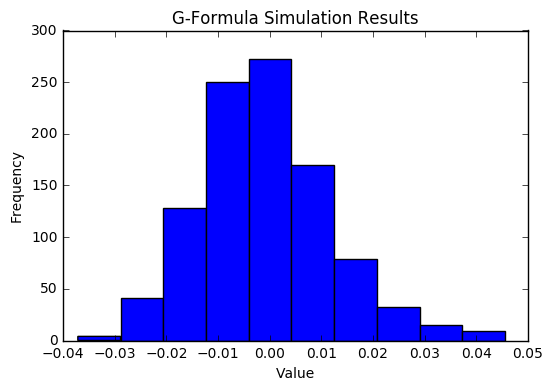

In [49]:
%matplotlib inline
plt.hist(results_g_formula)
plt.title("G-Formula Simulation Results")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.savefig('g-formula-sim.png', bbox_inches='tight')

(array([   1.,    1.,    1.,    1.,  992.,    0.,    1.,    1.,    0.,    2.]),
 array([-0.31307606, -0.24472614, -0.17637623, -0.10802631, -0.03967639,
         0.02867353,  0.09702344,  0.16537336,  0.23372328,  0.3020732 ,
         0.37042311]),
 <a list of 10 Patch objects>)

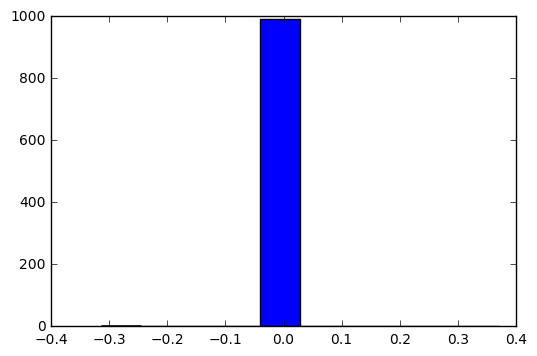

In [41]:
plt.hist(results_dr_estimator)
plt.title("G-Formula Simulation Results")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.savefig('g-formula-sim.png', bbox_inches='tight')

In [422]:
plotly.tools.set_credentials_file(username='mbreitmeyer2', api_key='dw8PAElGZsFlMHarQZcb')

fig = plt.figure()
data = [go.Histogram(x = results_g_formula)]
py.iplot(data)


NameError: name 'results_g_formula' is not defined

In [86]:
fig = plt.figure()
data = [go.Histogram(x = results_dr_estimator)]
py.iplot(data)

In [938]:
trace1 = go.Histogram(
    x=results_g_form_df.difference,
    opacity=0.75, 
    name = "G-formula"
)
trace2 = go.Histogram(
    x=results_dr_bin_df.difference,
    opacity=0.75, 
    name = "DR estimator"
)

data = [trace2, trace1]
layout = go.Layout(barmode='overlay', xaxis = dict(range = [-0.1, 0.1]))

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='overlaid_histogram')

In [942]:
print(np.mean(np.absolute(results_dr_bin_df.difference)))
print(np.mean(np.absolute(results_g_form_df.difference)))

0.030767222441063457
0.015947726700425487


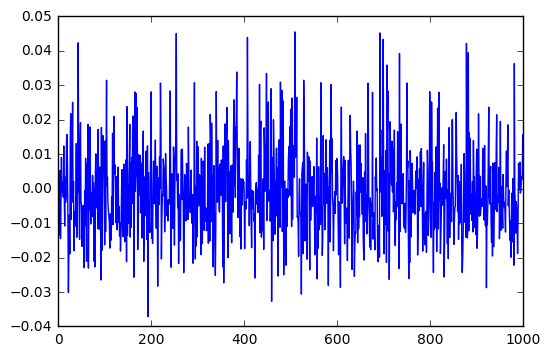

In [42]:
plt.plot(results_g_formula)

In [96]:
results_g_form_df

trace1 = go.Scatter(
    x=results_g_form_df.difference,
    name='G Form'
)
trace2 = go.Scatter(
    x=results_dr_bin_df.difference,
    name='LR DR'
)
data = [trace1, trace2]
layout = go.Layout(xaxis = dict(range = [-0.1, 0.1]))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

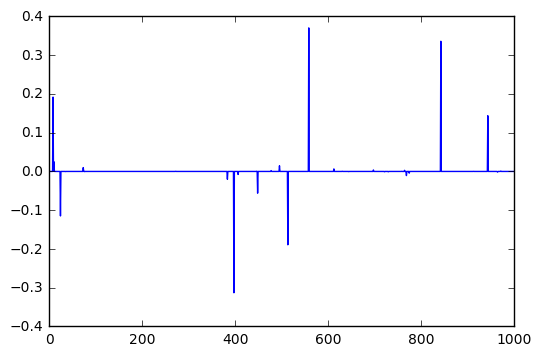

In [43]:
plt.plot(results_dr_estimator)

In [301]:
len(df+1)

12000

In [303]:
len(df)+1

12001